## Analyse de l'inflation sous-jacente
### Une comparaison analytique entre <br/>les m√©thodes statistiques classiques et les mod√®les de machine learning

<p>
Ce notebook pr√©sente de la partie pratique de l'analyse et de la mod√©lisation (ARIMA, VAR, RNA, XGBoost), √©labor√© dans le cadre de mon projet de fin d‚Äô√©tudes du Mastre en Statistique et √âconom√©trie (MSE) ‚Äì FSR/UM5.
</p>

#### Objectif :
R√©aliser une √©tude analytique des mod√®les afin d‚Äôidentifier celui qui mod√©lise et pr√©voit mieux l‚Äôinflation sous-jacente.
#### La d√©marche :
Nous avons un √©chantillon de l'isj(Maroc) entre 2018-2024, nous avons d√©versifi√© la taille de dataset pour pouvoir tester plusieus situations. 
<dl>
    <dt>- T = 28 (√©chantillon r√©duit) fr√©quence : Trimistielle</dt>
    <dt>- T = 84 (√©chantillon √©tendu) fr√©quence : Mensuelle</dt>
    <dt>- Univari√©e k = 1 (la variable cible)</dt>
    <dt>- Multivari√©e simple k = 4 (la variable endog√®ne + 3 variables exog√®nes causales)</dt>
    <dt>- Multivari√©e complexe(Des variables additionnelles pouvant avoir une interaction avec la variable cible) k = 7</dt>
    <dt>- La validation crois√©e : 80% d'entrainement 20% de test</dt>
    <dd> * Tester la capabilit√© d'apprendre sur les donn√©es vues (80%) et de g√©n√©raliser sur des donn√©es non vues(20%)</dd>
    <dt>- La comparaison entre l'impl√©mentaion manuelle de processus de mod√©lisation et l'utilisation de bliblioth√®que</dt>
    <dd> * l'objective : valider la robustesse de l'impl√®mentation manuelle.</dd>
    <td>Un tableau contient tous les r√©sultats, pour une analyse comparative et pour r√©pondre aux questions :</td>
    <dd> * Laquelle de ces deux approches mod√®lise et pr√©voit mieux l'isj, ainsi quel est le mod√®le le plus performant ?</dd>
    <dd> * Est ce que les mod√®les d'apprentissage automatique peuvent surpasser les m√©thodes statistiques?</dd>
</dl>
 
#### Les donn√©es : Description des variables

| Variable                           | Unit√© de mesure      | Notation | Source | P√©riodicit√©       |
|------------------------------------|----------------------|----------|--------|-------------------|
| Taux de l‚Äôinflation sous-jacente   | %                    | tx_isj   | BAM    | Mensuelle (M)     |
| Masse mon√©taire                    | 10‚Å∂ DH               | mm       | MEF    | Annuelle (A)      |
| Taux de croissance                 | %                    | tx_croi  | HCP    | Trimestrielle (T) |
| Taux directeur                     | %                    | tx_dire  | BAM    | Trimestrielle (T) |
| Taux de change                     | %                    | tx_chng  | BAM    | Trimestrielle (T) |
| Taux de ch√¥mage                    | %                    | tx_chmg  | HCP    | Trimestrielle (T) |
| Indice des valeurs √† l‚Äôimportation | indice (base 100)    | ivim     | HCP    | Trimestrielle (T) |
-----------------------------------------------------------------------------------------------------
<p style="fontfont-family: 'Arial', sans-serif; font-size: 16px;">** Les donn√©es disponibles sur les sites officiels de BAM, HCP et MEF<br/>
** Une particularit√© de la p√©riode √©tudi√©e r√©side dans la survenue de chocs exog√®nes : crise sanitaire, conflits g√©opolitiques, conditions m√©t√©orologiques marqu√©es par une s√©cheresse persistante, ainsi qu‚Äôun s√©isme dans la r√©gion d‚ÄôEl Haouz.</p>

##### Importation des librairies :

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import grangercausalitytests
from numpy.linalg import eigvals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Mod√®les statistiques et ML
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
import tensorflow as tf
import random

# √âvaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

import sys

##### Chargement des donn√©es de Excel :

In [2]:
def reload_data(freq) :
    file_path = "dataset.xlsx"
    if freq == "MS":
        df = pd.read_excel(file_path, sheet_name="Data_M", parse_dates=["M"])
        df.set_index("M", inplace=True)
    else :
        df = pd.read_excel(file_path, sheet_name="Data_T", parse_dates=["T"])
        df.set_index("T", inplace=True)

    df.index = pd.to_datetime(df.index)   # s‚Äôassurer que l‚Äôindex est bien datetime 
    if freq == "MS" : df.index = pd.date_range(start="2018-01-01", periods=len(df), freq="MS") 
    else : 
        df.index = pd.date_range(start="2018-01-01", periods=len(df), freq="QS")

    return df

##### Les fonctions n√©cissaires pour la mod√©lisation : ARIMA, VAR, RNA, XGBoost.

In [3]:
def histogram(serie):
    plt.plot(serie)
    plt.title("S√©rie chronologique-Inflation sous jacente(Maroc)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.show()
    
"""
    Tester la stationnarit√© : retourne list staionnaire et nombre de stationnaire d
"""
list_stationnaires = pd.DataFrame(columns=['serie', 'd']) # √† rinitialiser avant utiliser 'test_Stationnarite'
def test_Stationnarite(title, serie, d=0):
    result = adfuller(serie)
    if result[1] <= 0.05:
        list_stationnaires.loc[len(list_stationnaires)] = [title, d]
        return serie, d
    else:
        serie_diff = serie.diff().dropna() #Diff√©renciation + suppression des vides
        return test_Stationnarite(title, serie_diff, d=d + 1)

"""
    S√©parer la liste : retourne split_index, train, test
"""
def split_data(data) :
    n = len(data)
    split_index = int(n * 0.8)
    train = data.iloc[:split_index]
    test = data.iloc[split_index:]
    return split_index, train, test
"""
    calcule rho_k (ACF) pour k=0...nlags
    return x : 1D array-like
"""
def rho_k(x, nlags):
    x = np.asarray(x).astype(float)
    x = x[~np.isnan(x)]
    n = len(x)
    mu = x.mean()
    # biased estimator (divis√© par n) ‚Äî coh√©rent avec defs classiques
    gamma0 = np.sum((x - mu)**2) / n
    rho = np.empty(nlags + 1)
    rho[0] = 1.0
    for k in range(1, nlags + 1):
        gamma_k = np.sum((x[k:] - mu) * (x[:-k] - mu)) / n
        rho[k] = gamma_k / gamma0 if gamma0 != 0 else 0.0
    return rho

"""
    Levinson-Durbin recursion : calcul les phi_kk.
    Entr√©e r : array de lags autocorr r[0..nlags] (r[0]=1)
    Retourne:
      - phi_diag : array des phi_{k,k} pour k=1..nlags
      - phi_all  : tableau phi[k][j] (k=1..nlags, j=1..k) si besoin
      - sigma2   : pr√©diction erreur √† chaque √©tape
"""
def levinson_durbin(r, nlags):
    phi = np.zeros((nlags+1, nlags+1))   # phi[k, j] : for order k, coefficient j (1-based)
    sigma2 = np.zeros(nlags+1)
    sigma2[0] = 1.0  
    # recursion
    for k in range(1, nlags+1):
        if k == 1:
            phi[k,1] = r[1]
            sigma2[k] = sigma2[k-1] * (1 - phi[k,1]**2)
        else:
            # compute reflection (kth) coefficient
            num = r[k] - sum(phi[k-1, j] * r[k-j] for j in range(1, k))
            den = sigma2[k-1]
            if den == 0:
                kk = 0.0
            else:
                kk = num / den
            # update phi
            for j in range(1, k):
                phi[k, j] = phi[k-1, j] - kk * phi[k-1, k-j]
            phi[k, k] = kk
            sigma2[k] = sigma2[k-1] * (1 - kk**2)
    # extract diagonal phi_{k,k}
    phi_diag = np.array([phi[k,k] for k in range(1, nlags+1)])
    return phi_diag, phi, sigma2


def acf_pacf_table(series, nlags=10, alpha=0.05):
    """
    Retourne un tableau (DataFrame) avec rho_k (ACF), phi_kk (PACF diagonale),
    et indique si chaque lag est significatif.
    """
    x = np.asarray(series).astype(float)
    x = x[~np.isnan(x)]
    N = len(x)

    # IC th√©orique
    z = norm.ppf(1 - alpha/2)
    ci = round(z / np.sqrt(N), 4)

    rho = rho_k(x, nlags)# ACF
    phi_diag, _, _ = levinson_durbin(rho, nlags)# PACF via Levinson-Durbin
    rows = []
    for k in range(1, nlags+1):
        rows.append({
            "Lag": k,
            "ACF (rho_k)": round(float(rho[k]), 4),
            "Signif ACF": "Oui" if abs(rho[k]) > ci else "Non",
            "PACF (phi_kk)": round(float(phi_diag[k-1]), 4),
            "Signif PACF": "Oui" if abs(phi_diag[k-1]) > ci else "Non",
            "IC" : f"[-{ci}, +{ci}]"
        })

    return pd.DataFrame(rows)

# Variables globales
B_est_opt, Y_est_opt, Sigma_u_opt, residus_opt = [], [], [], []
aic_min, sc_min, p_opt = 0, 0, 0
"""
    R√©gression MCO pour une s√©rie univari√©e (AR(p)).
    Retourne : B_est, Y_est, residus, Sigma_u, T, k, X, Y
"""
def mco_univariee(data, p):
    # data : pandas.Series ou ndarray 1D
    if hasattr(data, "values") : y = data.values
    else : y = np.asarray(data)
    T = y.shape[0]   # nombre d'observations
    k = 1            # une seule variable d√©pendante
    Y = y[p:].reshape(-1, 1)  # (T-p, 1)
    # Construction de la matrice des retards
    X_lags = np.column_stack([y[p - i - 1:T - i - 1] for i in range(p)])  # (T-p, p)
    # Ajouter la constante
    X = np.hstack([np.ones((X_lags.shape[0], 1)), X_lags])  # {(T-p, p+1)}
    B_est = np.linalg.pinv(X.T @ X) @ (X.T @ Y)  # Estimation des coefficients MCO {(p+1, 1)}
    Y_est = X @ B_est  # Valeurs pr√©dites {(T-p, 1)}
    residus = Y - Y_est  # R√©sidus {(T-p, 1)}
    Sigma_u = ((residus.T @ residus) / (T - p)).item()  # Variance des r√©sidus (Sigma_u) {scalaire}
    return B_est, Y_est, residus, Sigma_u, T, k, X, Y

"""
    R√©gression MCO pour une s√©rie multivari√©e (AR(p)).
    Retourne : B_est, Y_est, residus, Sigma_u, T, k, X, Y
"""
def mco_multivariee(data, p):
    T, k = data.shape  # T = obs, k = variables
    # Construction Y et X
    Y = data[p:]
    X = np.hstack([data[p - i - 1:T - i - 1] for i in range(p)])  # sans constante
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # ajouter constante
    # Estimation MCO
    B_est = np.linalg.inv(X.T @ X) @ (X.T @ Y.values)
    Y_est = X @ B_est
    # R√©sidus (on recr√©e √† chaque appel)
    residus = Y.values - Y_est
    Sigma_u = (residus.T @ residus) / (T - p)
    return B_est, Y_est, residus, Sigma_u, T, k, X, Y
"""
    Calcule AIC et SC pour un AR(p) √† partir de la s√©rie 'data'.
"""
def ordre_p_optimal(data, p, type_data):
    _, _, _, Sigma_u, T, k, _, _ = mco_univariee(data, p) if type_data == "univari√©e" else mco_multivariee(data, p)
    log_det = np.log(Sigma_u) if type_data == "univari√©e" else np.log(np.linalg.det(Sigma_u))
    n_param = k * k * p  
    aic = log_det + (2 * n_param) / (T - p)
    sc = log_det + (n_param * np.log(T - p)) / (T - p)
    return aic, sc

def metriques(title, train_real, train_hat, test_real, test_hat):
    print(title)
    print(f"   Train : MSE={mean_squared_error(train_real, train_hat):.4f} | MAE={mean_absolute_error(train_real, train_hat):.4f} | R¬≤={r2_score(train_real, train_hat):.4f}")
    print(f"   Test  : MSE={mean_squared_error(test_real, test_hat):.4f} | MAE={mean_absolute_error(test_real, test_hat):.4f} | R¬≤={r2_score(test_real, test_hat):.4f}")

def residual_diagnostics(residus, lag, alpha=0.05):
    if hasattr(residus, "values") : r = residus.values
    else : r = np.asarray(residus)

    # Ljung-Box
    lb_res = acorr_ljungbox(r, lags=[lag], return_df=True)
    lb_Q, lb_p = (lb_res['lb_stat'].iloc[0], lb_res['lb_pvalue'].iloc[0])
    
    # Ljung-Box sur carr√©s
    lb_sq = acorr_ljungbox(r**2, lags=[lag], return_df=True)
    lb_Q_sq, lb_p_sq = (lb_sq['lb_stat'].iloc[0], lb_sq['lb_pvalue'].iloc[0])
    
    # Test ARCH
    lm_stat, lm_pval, f_stat, f_pval = het_arch(r, nlags=lag)
    
    # Jarque-Bera
    jb_stat, jb_pval = stats.jarque_bera(r)
    
    out = pd.DataFrame([
        {"Test": f"Ljung-Box (r√©sid, lag={lag})", "Stat": lb_Q, "p-value": lb_p,
         "D√©cision": "Rejeter H0 (autocorr.)" if lb_p < alpha else "Ne pas rejeter H0"},
        {"Test": f"Ljung-Box (r√©sid^2, lag={lag})", "Stat": lb_Q_sq, "p-value": lb_p_sq,
         "D√©cision": "Rejeter H0 (effets ARCH)" if lb_p_sq < alpha else "Ne pas rejeter H0"},
        {"Test": f"ARCH (nlags={lag}) ‚Äì LM", "Stat": lm_stat, "p-value": lm_pval,
         "D√©cision": "Rejeter H0 (h√©t√©rosc√©dasticit√©)?" if lm_pval < alpha else "Ne pas rejeter H0"},
        {"Test": f"ARCH (nlags={lag}) ‚Äì F", "Stat": f_stat, "p-value": f_pval,
         "D√©cision": "Rejeter H0 (h√©t√©rosc√©dasticit√©)?" if f_pval < alpha else "Ne pas rejeter H0"},
        {"Test": "Jarque‚ÄìBera (normalit√©)", "Stat": jb_stat, "p-value": jb_pval,
         "D√©cision": "Rejeter H0 (non-normalit√©)" if jb_pval < alpha else "Ne pas rejeter H0"
        }
    ])
    return out

def visualisation(title, train, test, train_pred, test_pred, train_pred_bibl, test_pred_bibl, p, d, freq):
   # Supposons que tu as d√©j√† d√©fini train et test
    train_index = df['tx_isj'].index[p + d:len(train)]
    test_index  = df['tx_isj'].index[len(train):len(train)+len(test)]
    plt.figure(figsize=(12,6))
    plt.plot(df['tx_isj'], label="R√©el - Train & Test", color="blue")
    # Cr√©er des Series avec index de df
    if len(train_pred) > 0 :
        train_pred      = pd.Series(train_pred,      index=train_index)
        plt.plot(train_pred, label="Pr√©vu Train", linestyle="--", color="green")
    if len(test_pred) > 0 :
        test_pred       = pd.Series(test_pred,       index=test_index)
        plt.plot(test_pred, label="Pr√©vu Test", linestyle=":", color="green")
    if len(train_pred_bibl) > 0 :
        train_pred_bibl = pd.Series(train_pred_bibl, index=train_index)
        plt.plot(train_pred_bibl, label="Pr√©vu Train Bibl", linestyle="--", color="red")
    if len(test_pred_bibl) > 0 :
        test_pred_bibl  = pd.Series(test_pred_bibl,  index=test_index)
        plt.plot(test_pred_bibl, label="Pr√©vu Test Bibl", linestyle=":", color="red")
    plt.axvline(x=train_index[-1], color="orange", linestyle=":", label="S√©paration Train/Test")
    plt.title(title)
    plt.xlabel(f"p√©riode[2018-2024]   ('{freq}', T= {84 if freq == 'MS' else 28})")
    plt.ylabel("tx_isj")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C = [] # Cte
A = [] # Extraire les matrices Ai
np.set_printoptions(precision=4, suppress=True)
"""
    Calculer la matrice compagnon : return F
"""
def matrice_compagonon(B_est, p, k):
    global C, A
    C = []
    A = []
    # Extraire la constante
    C = B_est[0:1, :].T
    print("Cst : ", C.shape)

    for i in range(p):
        Ai = B_est[k*i + 1:k*(i+1) + 1, :].T
        A.append(Ai)
        print(f"A{i+1}  : ", Ai.shape)

    # Construire matrice compagnon
    top = np.hstack(A)
    bottom = np.eye(k*(p-1), k*p)
    return np.vstack([top, bottom])

"""
    Verifier la stabilit√© le syst√®me :
"""
def stability_system(F, p) :
    # Valeurs propres
    eigenvalues = eigvals(F)
    print("Valeurs propres:\n", eigenvalues)
    if np.all(np.abs(eigenvalues) < 1) : 
        print(f" Le mod√®le VAR({p}) est stable.")
        return True
    else : 
        print(f" Le mod√®le VAR({p}) n'est pas stable")
        return False

target = 'tx_isj'
summary = []
non_causales = []
var_causales = []
"""
    Tester la causalit√© : Teste la causalit√© de Granger de chaque variable vers la variable cible.
    Affiche la p-valeur du test de Fisher.
"""
def test_causalite(data, p) :
    print(f"\nTest de causalit√© de Granger : les variables causales et les lags qui correpondent p = {p}")
    summary.clear()
    non_causales.clear()
    var_causales.clear()
    for var in data.columns.drop(target):
        causale = False
        resultat = grangercausalitytests(df[[target, var]], maxlag=p, verbose=False)
        for lag in range(1, p + 1):
            p_value = resultat[lag][0]['ssr_ftest'][1]
            if p_value < 0.05 : 
                var_causales.append({"variable": var, "lag": lag, "p_value": round(p_value,3)})
                causale = True  # au moins une causalit√© trouv√©e
        
        if causale == False and var != target :
            non_causales.append(var)
    print(pd.DataFrame(var_causales))

#### 1. ARIMA :

##### 1.1. Impl√®mentation manuelle :

In [4]:
# Initialisation :
freq = "MS" # {"MS"|"QS"}  √©chantillon: {√©tendu|reduit} Freq: {Mensuelle|Trimestrielle}
df = reload_data(freq) 
target = 'tx_isj'
serie = df["tx_isj"].dropna()

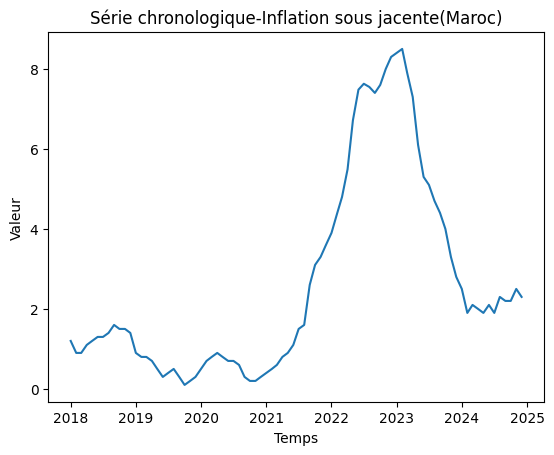

1. par la pr√©senation graphique : la pr√©sence d'une tendance indique la non-stationnarit√©
2. s√©gmnentons l'√©ch en 2 sous-√©ch : une s√©rie est stationnaire si : la E(Xi), la V(Xi) , cov(Xt, Xt+s) 
ne d√©pends pas de t mais de lag s 'la covariance entre Xt et Xt+s doit √™tre la m√™me quel 
que soit t' doivent √™tre toutes constante
Segment 1 : Moyenne = 0.764  | Variance = 0.166
Segment 2 : Moyenne = 4.492  | Variance = 5.462

Autocovariances :
Lag 1 : Segment 1 = 0.1623 | Segment 2 = 5.2593
Lag 2 : Segment 1 = 0.1654 | Segment 2 = 5.0826
Lag 3 : Segment 1 = 0.1692 | Segment 2 = 4.9865
ni la moyenne, ni la varaiance, ni les cov sont constantes : pas de stationnarit√© au sens large
3. Le test de racine unitaire : Test de Ducky Foller 
=> La s√©rie est sationnaris√©e apr√©s 1 diff√©rentiation(s) (d = 1)


In [5]:
# 1 - Stationnarit√© :
if len(serie) == 0 :
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
histogram(serie)
print("1. par la pr√©senation graphique : la pr√©sence d'une tendance indique la non-stationnarit√©")
y1 = serie[:len(serie)//2]
y2 = serie[len(serie)//2:]

print("2. s√©gmnentons l'√©ch en 2 sous-√©ch : une s√©rie est stationnaire si : "\
    "la E(Xi), la V(Xi) , cov(Xt, Xt+s) \n" \
"ne d√©pends pas de t mais de lag s 'la covariance entre Xt et Xt+s doit √™tre la m√™me quel \n" \
"que soit t' doivent √™tre toutes constante")
print("Segment 1 : Moyenne =", round(np.mean(y1), 3), " | Variance =", round(np.var(y1), 3))
print("Segment 2 : Moyenne =", round(np.mean(y2), 3), " | Variance =", round(np.var(y2), 3))
def autocovariance(series, lag):
    n = len(series)
    mean = np.mean(series)
    return np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
lags = [1, 2, 3]
print("\nAutocovariances :")
for k in lags:
    cov1 = autocovariance(y1, k)
    cov2 = autocovariance(y2, k)
    print(f"Lag {k} : Segment 1 = {cov1:.4f} | Segment 2 = {cov2:.4f}")
print("ni la moyenne, ni la varaiance, ni les cov sont constantes : pas de stationnarit√© au sens large")

list_stationnaires = pd.DataFrame(columns=['serie', 'd'])# doit √™tre reinitilaiser avant 'test_Stationnarite'
serie_stationnaire, d = test_Stationnarite("tx_isj", serie)
print("3. Le test de racine unitaire : Test de Ducky Foller ")
print(f"=> La s√©rie est sationnaris√©e apr√©s {d} diff√©rentiation(s) (d = {d})")

In [6]:
# 2 - D√©coupage :
if len(serie_stationnaire) == 0 :
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
split_index, train_arima, test_arima = split_data(serie_stationnaire)
print(f"=> Le d√©coupage : Train {train_arima.shape} et Test {test_arima.shape}")

=> Le d√©coupage : Train (66,) et Test (17,)


In [7]:
# 3 - L'autocorr√©lation (ACF) et l'autocorr√©lation partialle (PACF)
if len(serie_stationnaire) == 0 :
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
print(acf_pacf_table(serie_stationnaire, nlags=10).to_string(index=False))
print("=> Les ordres signifcatifs : p = {1, 4}         |  d = 1  |  q = 2 pour T=28")
print("=> Les ordres signifcatifs : p = {1, 5, 9, 10}  |  d = 1  |  q = 8 pour T=84")

 Lag  ACF (rho_k) Signif ACF  PACF (phi_kk) Signif PACF                 IC
   1       0.6587        Oui         0.6587         Oui [-0.2151, +0.2151]
   2       0.5123        Oui         0.1385         Non [-0.2151, +0.2151]
   3       0.4082        Oui         0.0472         Non [-0.2151, +0.2151]
   4       0.2467        Oui        -0.1274         Non [-0.2151, +0.2151]
   5       0.3446        Oui         0.3238         Oui [-0.2151, +0.2151]
   6       0.2860        Oui        -0.0634         Non [-0.2151, +0.2151]
   7       0.3056        Oui         0.1293         Non [-0.2151, +0.2151]
   8       0.3614        Oui         0.0862         Non [-0.2151, +0.2151]
   9       0.1623        Non        -0.2543         Oui [-0.2151, +0.2151]
  10      -0.0193        Non        -0.3536         Oui [-0.2151, +0.2151]
=> Les ordres signifcatifs : p = {1, 4}         |  d = 1  |  q = 2 pour T=28
=> Les ordres signifcatifs : p = {1, 5, 9, 10}  |  d = 1  |  q = 8 pour T=84


In [8]:
# 4 - les ordres optimal : par MCO (MCO plus simple mais ne prend pas en cons√©d√®ration MA(q), 
# MLE, oui ce qui le rends plus performant pour estim√© aic)
if len(serie_stationnaire) == 0 :
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
max_p = 10
result_aic = []
for p in range(1, max_p + 1):
    aic, sc = ordre_p_optimal(serie_stationnaire, p, "univari√©e")
    if p == 1 :
        aic_min = aic 
        sc_min = sc
        p_opt = p
    elif aic < aic_min : 
        aic_min = aic 
        sc_min = sc
        p_opt = p
    result_aic.append({"AIC" : round(aic, 3), "SC" : round(sc, 3), "p" : p})
print(pd.DataFrame(result_aic))
print(f"=> L'ordre optimal p: {p_opt} nous pouvons tester par la suite :")
print(pd.DataFrame(result_aic).nsmallest(3, 'AIC')[1:])

     AIC     SC   p
0 -2.583 -2.554   1
1 -2.568 -2.509   2
2 -2.541 -2.452   3
3 -2.520 -2.400   4
4 -2.604 -2.453   5
5 -2.571 -2.388   6
6 -2.550 -2.335   7
7 -2.519 -2.272   8
8 -2.577 -2.297   9
9 -2.653 -2.340  10
=> L'ordre optimal p: 10 nous pouvons tester par la suite :
     AIC     SC  p
4 -2.604 -2.453  5
0 -2.583 -2.554  1


In [9]:
# 5 - Estimation des coeficients AR(p) de ARIMA(p, d , q)
if len(train_arima) == 0 or p_opt == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
p = p_opt
q = 8 if freq == "MS" else 2 

B_est, Y_est, residus, Sigma_u, T, k, X, y = mco_univariee(train_arima, p)
# Matrice var-covar
var_B = Sigma_u * np.linalg.inv(X.T @ X)
se_B = np.sqrt(np.diag(var_B))
# t-stats et p-values
t_stats = B_est.flatten() / se_B
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=T - k)) for t in t_stats]
print(pd.DataFrame({
        'Coefficient': B_est.flatten(),
        'Std. Error': se_B,
        't-Statistic': t_stats,
        'p-Value': p_values}))

    Coefficient  Std. Error  t-Statistic       p-Value
0      0.010426    0.036352     0.286817  7.751650e-01
1      0.708368    0.128834     5.498320  6.907065e-07
2      0.058846    0.159342     0.369306  7.131000e-01
3     -0.010681    0.163021    -0.065518  9.479631e-01
4     -0.136428    0.165324    -0.825216  4.122673e-01
5      0.270626    0.172755     1.566537  1.220788e-01
6     -0.122366    0.174816    -0.699968  4.864448e-01
7      0.074042    0.176738     0.418935  6.766447e-01
8      0.354110    0.177222     1.998113  4.989155e-02
9     -0.134519    0.183013    -0.735026  4.649674e-01
10    -0.353310    0.154939    -2.280319  2.587656e-02


In [10]:
# 6 - Pr√©diction :
if len(Y_est) == 0 or p == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")

for lag in range(1, p + 1):  
    df[f"tx_isj_t-{lag}"] = df["tx_isj"].shift(lag)
df_clean = df.dropna()# Nettoyage
X_columns = [f"tx_isj_t-{lag}" for lag in range(1, p + 1)]
X = df_clean[X_columns].values[d:] # les features 

y_real_all = df_clean['tx_isj'].values[d:].reshape(-1, 1) # le label
y_pred_all = (B_est[:1] + X @ B_est[1:]).ravel() # avec C   {(T, k+1) * (k+1, k+1)}
#y_pred_all = X @ B_est # sans C    {(T, k) * (k, k)}

y_train_real = y_real_all[:split_index-p]
y_test_real  = y_real_all[split_index-p:]
y_train_pred = y_pred_all[:split_index-p]
y_test_pred  = y_pred_all[split_index-p:]

In [11]:
# 7 - Calcul des m√©triques
metriques(f"=> Performance de l'impl√®mentation manuelle de ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          y_train_real, y_train_pred, 
          y_test_real, y_test_pred)

=> Performance de l'impl√®mentation manuelle de ARIMA(10, 1, 8) T = 84 :
   Train : MSE=1.0036 | MAE=0.7593 | R¬≤=0.8854
   Test  : MSE=1.1968 | MAE=1.0738 | R¬≤=-0.5720


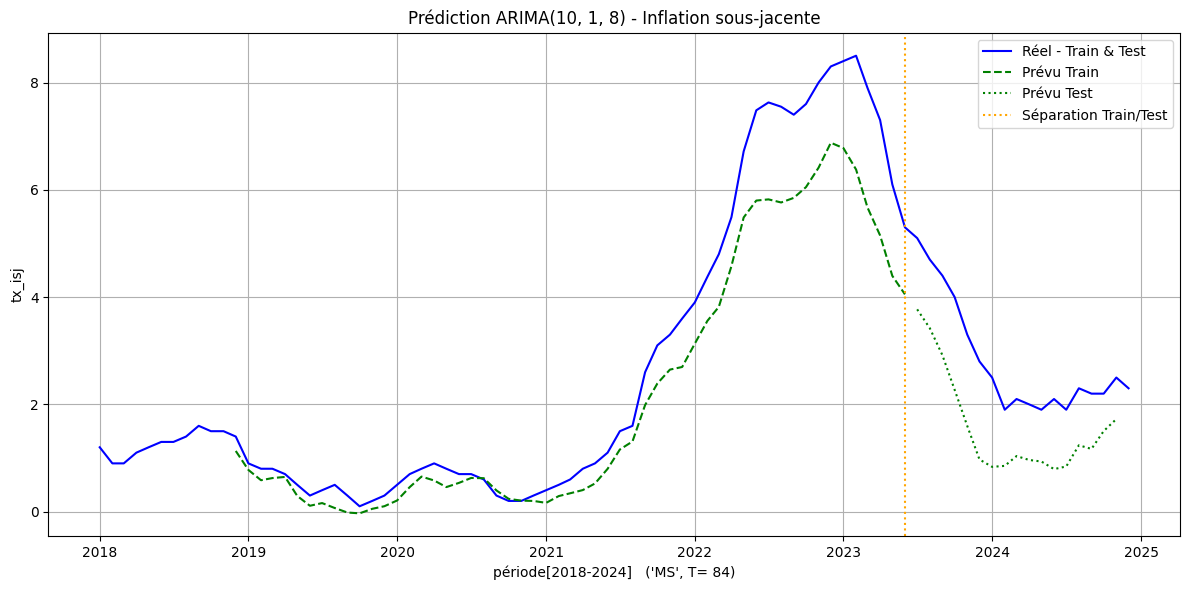

In [12]:
# 8 - Visualisation
if len(train_arima) == 0 or p == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
visualisation(f"Pr√©diction ARIMA({p}, {d}, {q}) - Inflation sous-jacente", 
              train_arima, test_arima,
              y_train_pred[d:], y_test_pred, 
              [], [], 
              p, d, freq)

##### 1.2. Utilisation de la biblioth√®que ARIMA :

=> Performance de la Biblioth√®que ARIMA(10, 1, 8) T = 84 :
   Train : MSE=0.0554 | MAE=0.1550 | R¬≤=0.9928
   Test  : MSE=2.0529 | MAE=1.3452 | R¬≤=-1.6966


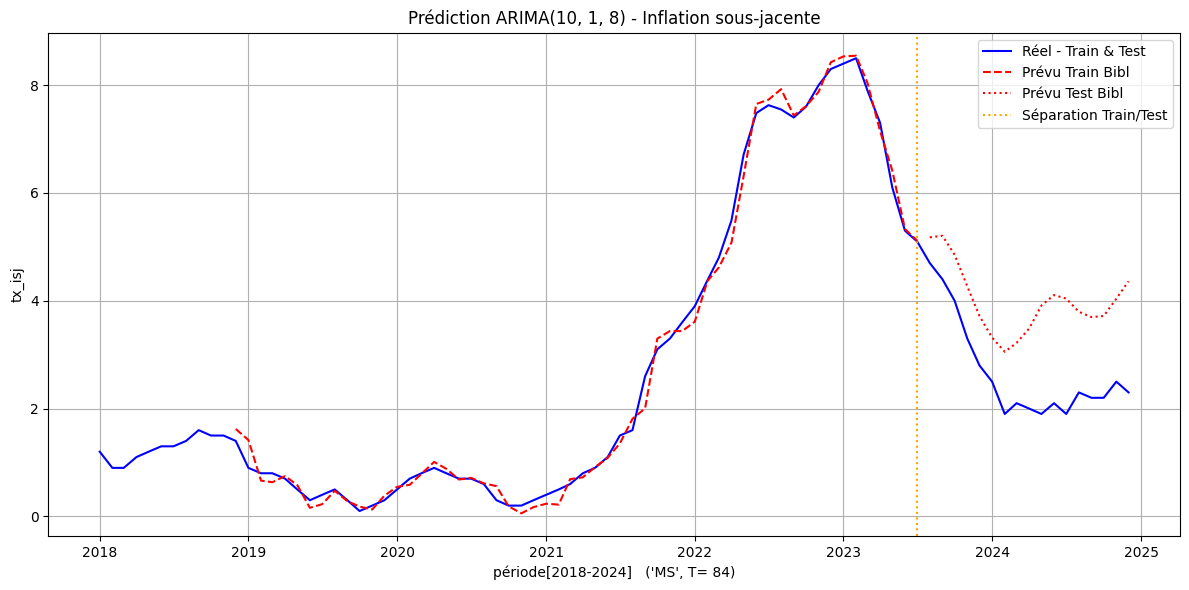

In [13]:
if len(serie) == 0 or p == 0 or d == 0 or q == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
split_index, train_arima, test_arima = split_data(serie) # non stationnaire
model = ARIMA(train_arima, order=(p, d, q), freq=freq)
results = model.fit()
residuals_bibl = results.resid
# Pr√©diction train et test : Statsmodels ARIMA g√®re d√©j√† la r√©int√©gration avec typ='levels'
train_pred_bibl = results.predict(start=train_arima.index[0], end=train_arima.index[-1], typ='levels')
test_pred_bibl = results.predict(start=test_arima.index[0], end=test_arima.index[-1], typ='levels')

metriques(f"=> Performance de la Biblioth√®que ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          train_arima, train_pred_bibl, 
          test_arima, test_pred_bibl)

visualisation(f"Pr√©diction ARIMA({p}, {d}, {q}) - Inflation sous-jacente", 
              train_arima, test_arima,
              [], [], 
              train_pred_bibl, test_pred_bibl, p, d, freq)

=> Performance de l'impl√®mentation manuelle de ARIMA(10, 1, 8) T = 84 :
   Train : MSE=1.0036 | MAE=0.7593 | R¬≤=0.8854
   Test  : MSE=1.1968 | MAE=1.0738 | R¬≤=-0.5720
=> Performance de la Biblioth√®que ARIMA(10, 1, 8) T = 84 :
   Train : MSE=0.0554 | MAE=0.1550 | R¬≤=0.9928
   Test  : MSE=2.0529 | MAE=1.3452 | R¬≤=-1.6966


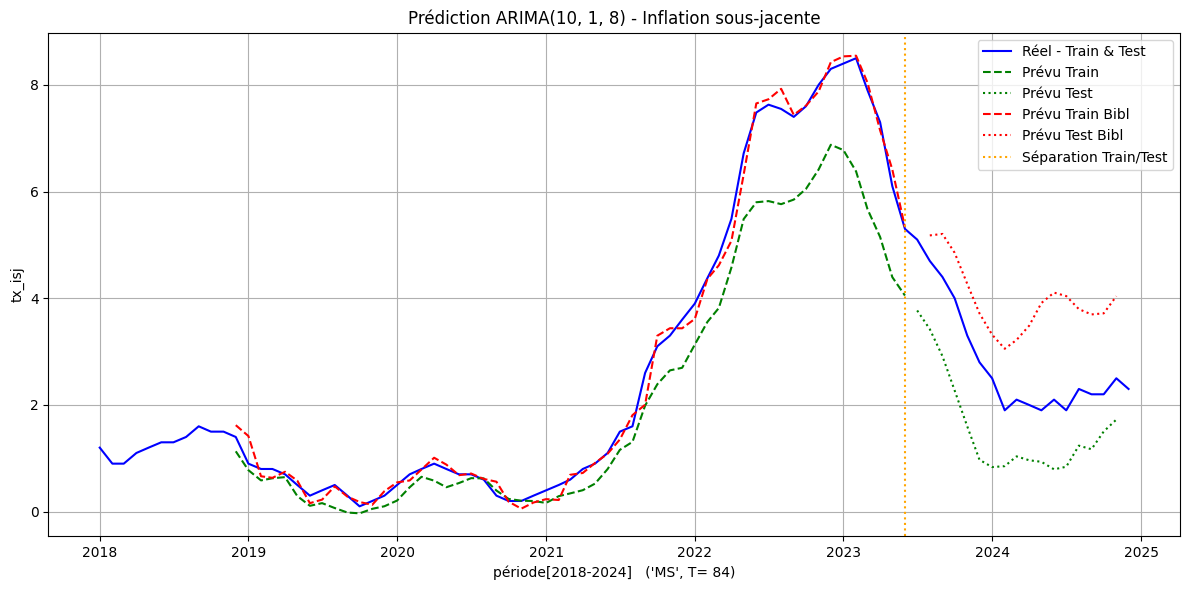

In [14]:
# 9 - Comparaison entre l‚Äôimpl√©mentation manuelle et l‚Äôutilisation de la biblioth√®que d√©di√©e
if len(train_arima) == 0 or p == 0 or d == 0 or q == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")

metriques(f"=> Performance de l'impl√®mentation manuelle de ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          y_train_real, y_train_pred, 
          y_test_real, y_test_pred)

metriques(f"=> Performance de la Biblioth√®que ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          train_arima, train_pred_bibl, 
          test_arima, test_pred_bibl)

visualisation(f"Pr√©diction ARIMA({p}, {d}, {q}) - Inflation sous-jacente", 
              train_arima[d:], test_arima,
              y_train_pred[d:], y_test_pred,
              train_pred_bibl, test_pred_bibl, 
              p, d, freq)

<p style="font-size:20px">Rappel : Pour valider le mod√®le, il est n√©cessaire d‚Äôeffectuer certains tests visant √† d√©tecter d‚Äô√©ventuelles violations des hypoth√®ses sur les erreurs :</p>
<p style="font-size:18px">Le test <b>Ljung-Box (r√©sidus, lag)</b> permet : de d√©tecter la corr√©lation entre erreurs √† un instant (lag), de v√©rifier si le mod√®le a correctement captur√© la dynamique de la s√©rie, car des r√©sidus autocorr√©l√©s indiquent un mod√®le mal ajust√©.<p/>
<p style="font-size:18px">Le test <b>Ljung-Box (r√©sidus¬≤, lag)</b> : teste l‚Äôautocorr√©lation dans la variance des r√©sidus pour d√©tecter des effets <b>d‚Äôh√©t√©rosc√©dasticit√© conditionnelle</b> (type ARCH), c‚Äôest-√†-dire si la volatilit√© des erreurs d√©pend de leurs valeurs pass√©es.<p/>
<p style="font-size:18px">Test <b>ARCH - LM</b> : test de Lagrange Multiplier qui √©value la pr√©sence d‚Äôun effet ARCH en regardant si les r√©sidus au carr√© sont autocorr√©l√©s. La statistique suit une loi du chi-deux, adapt√©e aux √©chantillons larges.<p/>
<p style="font-size:18px">Test <b>ARCH - F</b> : bas√©e sur une statistique F, plus appropri√©e pour les petits √©chantillons, teste √©galement la d√©pendance de la variance des r√©sidus dans le temps.<p/>
<p style="font-size:18px">Test <b>Jarque Bera</b> : teste la notmalit√© de distribution de r√©sidus.<p/>

In [15]:
# 10 - Validation de mod√®le : tester les violation des hypoth√®ses des erreurs
lags = 5
print(f"Diagnostics des r√©sidus de {lags} lags:")
print("Autocorr√©lation des r√©sidus :\n\tH_0: pasd‚Äôautocorr√©lation des r√©sidus;\n\tH_1:pr√©sence d‚Äôautocorr√©lation des r√©sidus")
print("H√©t√©rosc√©dasticit√© :\n\tH_0: variance constante (homosc√©dasticit√©);\n\tH_1:variance non constante (h√©t√©rosc√©dasticit√©)")
print("Normalit√© des r√©sidus :\n\tH_0: r√©sidus suivent une loi normale;\n\tH_1:r√©sidus ne suivent pas une loi normale")
for lag in range(1, lags + 1) :
    print(residual_diagnostics(residus, lag, alpha=0.05))
print("=> pas d'autocorr√©lation (les erreurs sont ind√©pendantes), " \
"pas d'h√©t√©rozc√©dasticit√© (leur variance est constane dans le temps) : \n\t Les r√©sidus sont du bruit blanc au sens strict" \
"\n\t Le mod√®le a correctement captur√© la dynamique de la s√©rie (aucune autocorr√©lation, pas d‚Äôeffet ARCH)." \
"\n\t L'anormalit√© des erreurs : Cela peut venir de queues lourdes, ou de distributions asym√©triques")

Diagnostics des r√©sidus de 5 lags:
Autocorr√©lation des r√©sidus :
	H_0: pasd‚Äôautocorr√©lation des r√©sidus;
	H_1:pr√©sence d‚Äôautocorr√©lation des r√©sidus
H√©t√©rosc√©dasticit√© :
	H_0: variance constante (homosc√©dasticit√©);
	H_1:variance non constante (h√©t√©rosc√©dasticit√©)
Normalit√© des r√©sidus :
	H_0: r√©sidus suivent une loi normale;
	H_1:r√©sidus ne suivent pas une loi normale
                         Test       Stat   p-value                    D√©cision
0    Ljung-Box (r√©sid, lag=1)   0.122001  0.726875           Ne pas rejeter H0
1  Ljung-Box (r√©sid^2, lag=1)   0.014576  0.903904           Ne pas rejeter H0
2         ARCH (nlags=1) ‚Äì LM   0.013624  0.907079           Ne pas rejeter H0
3          ARCH (nlags=1) ‚Äì F   0.013132  0.909199           Ne pas rejeter H0
4     Jarque‚ÄìBera (normalit√©)  14.937923  0.000571  Rejeter H0 (non-normalit√©)
                         Test       Stat   p-value                    D√©cision
0    Ljung-Box (r√©sid, lag=2)   1.883

##### 1.3. Analyse :

<pre>
<table>
   <tr><th>T</th><th>Impl√®mentation manuelle vs Usage du biblioth√®que</th></tr>
   <tr><td>28</td>
      <td>
=> Performance de l'impl√®mentation manuelle de ARIMA(4, 1, 2) T = 28 :
   Train : MSE=3.5926 | MAE=1.5284 | R¬≤=0.6050
   Test  : MSE=16.9274 | MAE=4.0564 | R¬≤=-16.6282
=> Performance de la Biblioth√®que ARIMA(4, 1, 2) T = 28 :
   Train : MSE=0.2520 | MAE=0.3905 | R¬≤=0.9669
   Test  : MSE=1.5659 | MAE=1.0561 | R¬≤=-0.6308
      </td>
   </tr>
   <tr><td>84</td>
      <td>
=> Performance de l'impl√®mentation manuelle de ARIMA(10, 1, 8) T = 84 :
   Train : MSE=1.0036 | MAE=0.7593 | R¬≤=0.8854
   Test  : MSE=1.1968 | MAE=1.0738 | R¬≤=-0.5720
=> Performance de la Biblioth√®que ARIMA(10, 1, 8) T = 84 :
   Train : MSE=0.0554 | MAE=0.1550 | R¬≤=0.9928
   Test  : MSE=2.0529 | MAE=1.3452 | R¬≤=-1.6966
      </td>
   </tr>
</table>
</pre>
Le mod√®le ARIMA a bien appris sur les donn√©es d‚Äôentra√Ænement, mais n‚Äôa pas r√©ussi √† g√©n√©raliser sur les donn√©es non vues. Cela met en √©vidence sa limite pour mod√©liser l‚Äôinflation sous-jacente, un indicateur macro√©conomique qu‚Äôil est tr√®s rare de pouvoir l'expliquer de mani√®re totalement ind√©pendante des autres variables. En raison de sa structure univari√©e, ARIMA n‚Äôa pas pu capturer la dynamique complexe de ce ph√©nom√®ne. Pour d√©passer cette limite, il est donc n√©cessaire de tester d‚Äôautres mod√®les capables de d√©tecter et d‚Äôexploiter les interactions dynamiques entre plusieurs variables.

#### 2. VAR :

##### 2.1 Impl√®mentation manuelle :

In [16]:
freq = "MS" # {"MS"|"QS"}  √©chantillon: {√©tendu|reduit} Freq: {Mensuelle|Trimestrielle}
df = reload_data(freq) 
target = 'tx_isj'

In [17]:
# 1 - Stationnarit√© :
vectors = []
list_stationnaires = pd.DataFrame(columns=['serie', 'd'])
for var in df.columns :
    vectors.append(test_Stationnarite(var, df[var], 0))  
df_stationnaire = pd.concat([v[0] for v in vectors], axis=1).dropna()
d = max(list_stationnaires['d']) # get d
print(f"{list_stationnaires}")
print(f"=> Les s√©ries sont sationnaris√©es apr√©s {d} diff√©rentiation(s) (d = {d})")

     serie  d
0   tx_isj  1
1  tx_croi  0
2  tx_dire  1
3       mm  1
4  tx_chmg  1
5  tx_chng  0
6     ivim  1
=> Les s√©ries sont sationnaris√©es apr√©s 1 diff√©rentiation(s) (d = 1)


In [18]:
# 2 - d√©coupage train/test
split_index, train_var, test_var = split_data(df_stationnaire)
print(f"=> Le d√©coupage : Train {train_var.shape} et Test {test_var.shape}")

=> Le d√©coupage : Train (66, 7) et Test (17, 7)


In [19]:
# 3 . chercher l'ordre optimal
if len(train_var) == 0 :
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
max_p = 5
result_aic = []
for p in range(1, max_p + 1):
    aic, sc = ordre_p_optimal(train_var, p, "multivari√©e")
    if p == 1 :
        aic_min = aic 
        sc_min = sc
        p_opt = p
    elif aic < aic_min : 
        aic_min = aic 
        sc_min = sc
        p_opt = p
    result_aic.append({"AIC" : round(aic, 3), "SC" : round(sc, 3), "p" : p})
print(pd.DataFrame(result_aic))
print(f"=> L'ordre optimal p: {p_opt}")

      AIC      SC  p
0 -19.451 -17.812  1
1 -19.789 -16.483  2
2 -20.166 -15.165  3
3 -19.965 -13.240  4
4 -20.103 -11.625  5
=> L'ordre optimal p: 3


In [20]:
if len(train_var) == 0 or p_opt == 0 or p == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
    
# 4 - La regression 
# 5 - Calcule du matrice compagnon
# 6 - Stabilit√© de syst√®me
while(p_opt>=1):
    B_est, Y_est, residus, Sigma_u, T, k,_, _ = mco_multivariee(train_var, p_opt)
    F = matrice_compagonon(B_est, p_opt, k)
    if stability_system(F, p_opt) == True : break
    else : p_opt = p_opt - 1

Cst :  (7, 1)
A1  :  (7, 7)
A2  :  (7, 7)
A3  :  (7, 7)
Valeurs propres:
 [-0.95  +0.j     -0.5821+0.1673j -0.5821-0.1673j -0.5707+0.j
 -0.336 +0.5752j -0.336 -0.5752j -0.0798+0.8139j -0.0798-0.8139j
 -0.182 +0.7202j -0.182 -0.7202j  0.5523+0.6427j  0.5523-0.6427j
  0.8685+0.165j   0.8685-0.165j   0.8175+0.1929j  0.8175-0.1929j
  0.4516+0.4788j  0.4516-0.4788j  0.5335+0.j      0.4418+0.298j
  0.4418-0.298j ]
 Le mod√®le VAR(3) est stable.



Test de causalit√© de Granger : les variables causales et les lags qui correpondent p = 3
  variable  lag  p_value
0  tx_dire    1    0.000
1  tx_dire    2    0.030
2       mm    3    0.008
3  tx_chng    1    0.000
4     ivim    1    0.011
5     ivim    3    0.021
=> L'extaction des variables non-causale ['tx_croi', 'tx_chmg'] : Train (66, 5) et Test {test_reduit.shape}
Cst :  (5, 1)
A1  :  (5, 5)
A2  :  (5, 5)
A3  :  (5, 5)
Valeurs propres:
 [ 0.9026+0.1572j  0.9026-0.1572j  0.5285+0.6268j  0.5285-0.6268j
  0.6999+0.3088j  0.6999-0.3088j -0.1147+0.8539j -0.1147-0.8539j
  0.0829+0.4692j  0.0829-0.4692j -0.3007+0.6235j -0.3007-0.6235j
 -0.9039+0.j     -0.604 +0.0694j -0.604 -0.0694j]
 Le mod√®le VAR(3) est stable.
[[ 0.4863  0.861  -4.6958 -0.052   0.0444]
 [ 0.0189  0.4998  0.082  -0.001  -0.0212]
 [-0.0233  0.0347 -0.8559 -0.01    0.0055]
 [ 0.1309 -1.2138  1.2098  0.5898  0.0207]
 [ 1.6057 -1.459  -0.9024 -0.3206  0.765 ]]
=> Performance de l'impl√®mentation manuelle de VAR(3) T = 8

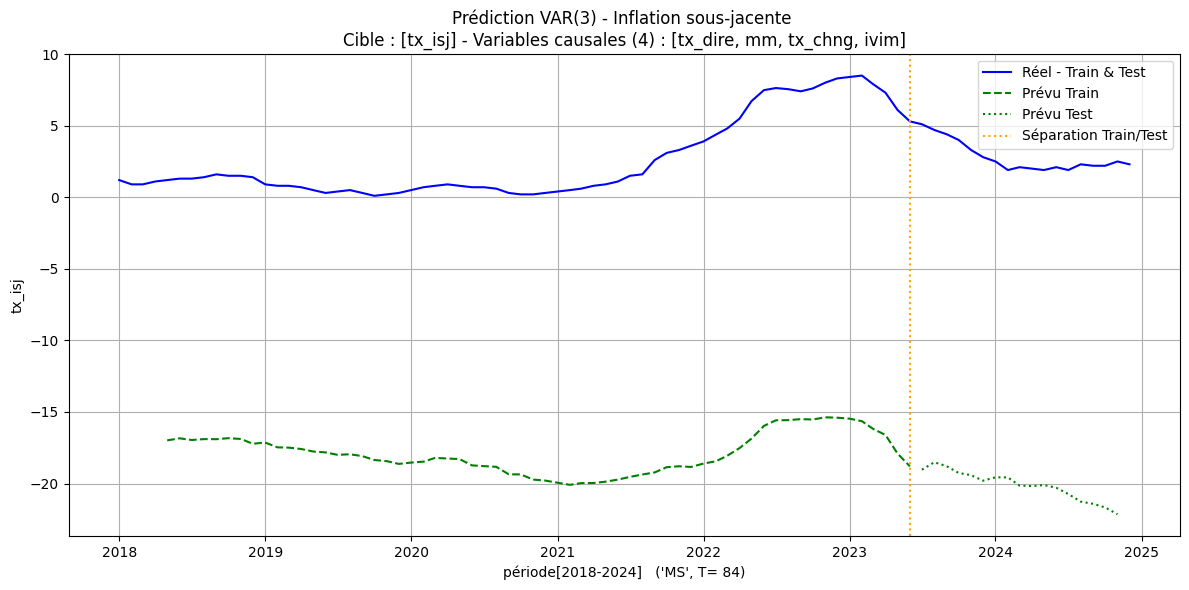

In [21]:
if len(train_var) == 0 or p_opt == 0 or p == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")

# 7 - Teste de causalit√©
test_causalite(train_var, p_opt)
df_stationnaire_reduit = df_stationnaire.drop(columns=non_causales)
split_index, train_reduit, test_reduit = split_data(df_stationnaire_reduit)
print(f"=> L'extaction des variables non-causale {non_causales} : Train {train_reduit.shape} et "\
       "Test {test_reduit.shape}")

# reRegression, reCalcul la matrice compagnon, et reTest la statbilit√© avec moins des variables (k=5)
B_est, Y_est, residus, Sigma_u, T, k,_ , _ = mco_multivariee(train_reduit, p_opt)
stability_system(matrice_compagonon(B_est, p_opt, k), p_opt)
df_reduit = df.drop(columns=non_causales)

print(A[0])

# 8 - la pr√©diction
def pred_var(df_stat_reduit, df_reduit, p):
    T, k = df_stat_reduit.shape
    Y_pred = np.zeros((T, k))
    for t in range(p, T):
        y_pred_t = C.copy()
        for i in range(p): y_pred_t += A[i] @ df_reduit.values[t - i - 1].reshape(-1, 1)
        Y_pred[t] = y_pred_t.ravel()

    j = df_reduit.columns.get_loc(target) # Cible
    # R√©el
    Y_train_real = df_reduit.values[:split_index, j]
    Y_test_real  = df_reduit.values[split_index:, j]   # v√©rifier d (d√©calage)

    Y_train_pred = Y_pred[:split_index, j]
    Y_test_pred  = Y_pred[split_index - d:, j]
    return Y_train_real, Y_train_pred, Y_test_real, Y_test_pred

(train_real_man, train_pred_man, 
 test_real_man, test_pred_man) = pred_var(df_stationnaire_reduit, df_reduit, p_opt)

# 9 - Calcul des m√©triques
metriques(f"=> Performance de l'impl√®mentation manuelle de VAR({p_opt}) T = {84 if freq=="MS" else 28}:", 
          train_real_man, train_pred_man, 
          test_real_man, test_pred_man)

# 10 - visualisation : 
causal_vars = [col for col in df_reduit.columns if col != target]
visualisation(f"Pr√©diction VAR({p_opt}) - Inflation sous-jacente \nCible : [{target}] - "
            f"Variables causales ({len(causal_vars)}) : [{', '.join(causal_vars)}]", 
              train_var, test_var,
              train_pred_man[p_opt+d:], test_pred_man[d:],
              [], [], 
              p_opt, d, freq)

##### 2.2. Utilisation de la biblioth√®que VAR (statsmodels) :

=> Performance de la Biblioth√®que VAR(3) T = 84:
   Train : MSE=0.0367 | MAE=0.1410 | R¬≤=0.7276
   Test  : MSE=0.1199 | MAE=0.2617 | R¬≤=-0.2907


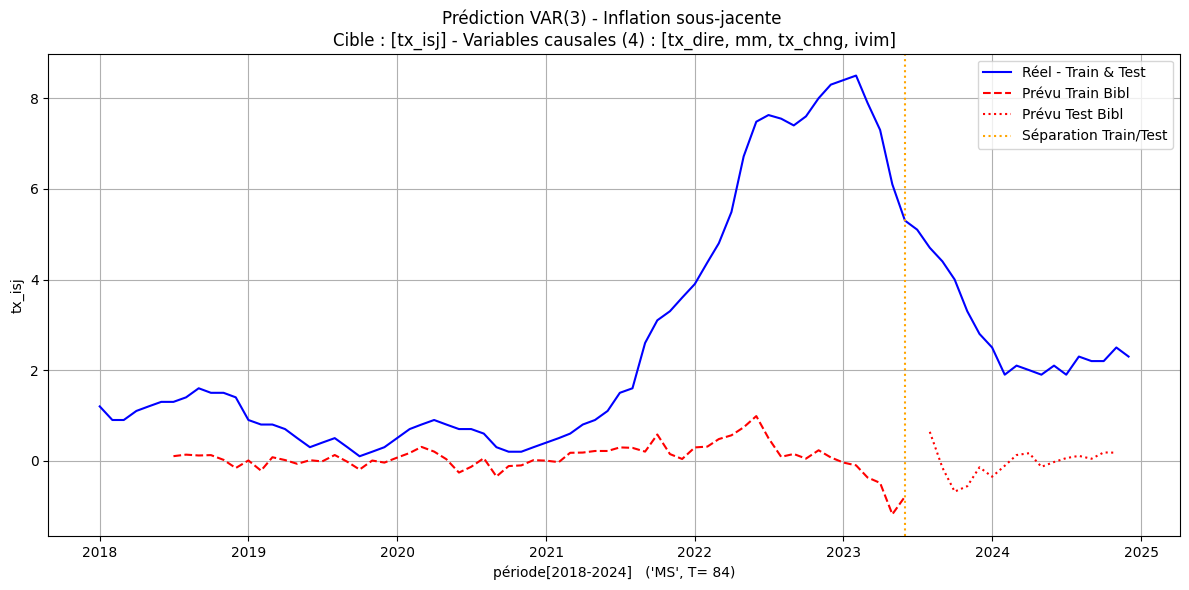

In [22]:
def bibl_var(p) : 
  if len(train_reduit) == 0 or p == 0:
    sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
  model_reduced = VAR(train_reduit)
  var_model = model_reduced.fit(p)

  train_pred = var_model.fittedvalues # Pr√©dictions entra√Ænement
  train_pred.index = train_reduit.index[var_model.k_ar:] # Ajuster l'index (VAR commence √† p)
  # Pr√©dictions test
  forecast = var_model.forecast(y=train_reduit.values, steps=len(test_reduit))
  forecast_df = pd.DataFrame(forecast, index=test_reduit.index, columns=train_reduit.columns)
  
  # R√©int√©gration (retour √† l‚Äô√©chelle originale)
  ind0 = train_reduit.index[0]
  last_known = df.loc[ind0]   # base pour cumsum
  train_pred_original = train_pred.cumsum() + last_known
  forecast_df_original = forecast_df.cumsum() + df.loc[train_reduit.index[-1]]

  # R√©cup√©rer la colonne cible dans les pr√©dictions VAR
  target_train_real = train_reduit[target].iloc[var_model.k_ar:]
  target_test_real  = test_reduit[target]

  target_train_pred = train_pred[target]
  target_test_pred  = forecast_df[target]
  return (target_train_real, target_train_pred, 
          target_test_real, target_test_pred, 
          train_pred_original, forecast_df_original)

(train_real_bibl, train_pred_bibl, 
 test_real_bibl, test_pred_bibl, 
 train_pred_orig, forecast_df_orig) = bibl_var(p_opt)

metriques(f"=> Performance de la Biblioth√®que VAR({p_opt}) T = {84 if freq=="MS" else 28}:", 
          train_real_bibl, 
          train_pred_bibl, 
          test_real_bibl, 
          test_pred_bibl)
# 10 - visualisation : 
causal_vars = [col for col in df_reduit.columns if col != target]
visualisation(f"Pr√©diction VAR({p_opt}) - Inflation sous-jacente \nCible : [{target}] - "
            f"Variables causales ({len(causal_vars)}) : [{', '.join(causal_vars)}]", 
              train_var, test_var,
              [], [],
              train_pred_bibl, test_pred_bibl, 
              p, d, freq)

<p style="font-size:20px">Le mod√®le VAR(3) pr√©sente une performance insatisfaisante, nous d√©cr√©mentons p et nous testons la causalit√© pour exclure plus des variables non-causale (-> un mod√®le paricimineux)</p>


Test de causalit√© de Granger : les variables causales et les lags qui correpondent p = 2
  variable  lag  p_value
0  tx_dire    1    0.000
1  tx_dire    2    0.030
2  tx_chng    1    0.000
3     ivim    1    0.011
Cst :  (4, 1)
A1  :  (4, 4)
A2  :  (4, 4)
=> Performance de l'impl√®mentation manuelle de VAR(2) T = 84 :
   Train : MSE=0.8525 | MAE=0.7975 | R¬≤=0.8894
   Test  : MSE=0.7115 | MAE=0.7076 | R¬≤=0.3114
=> Performance de la Biblioth√®que VAR(2) T = 84 :
   Train : MSE=0.0520 | MAE=0.1554 | R¬≤=0.6086
   Test  : MSE=0.0762 | MAE=0.2444 | R¬≤=0.1794


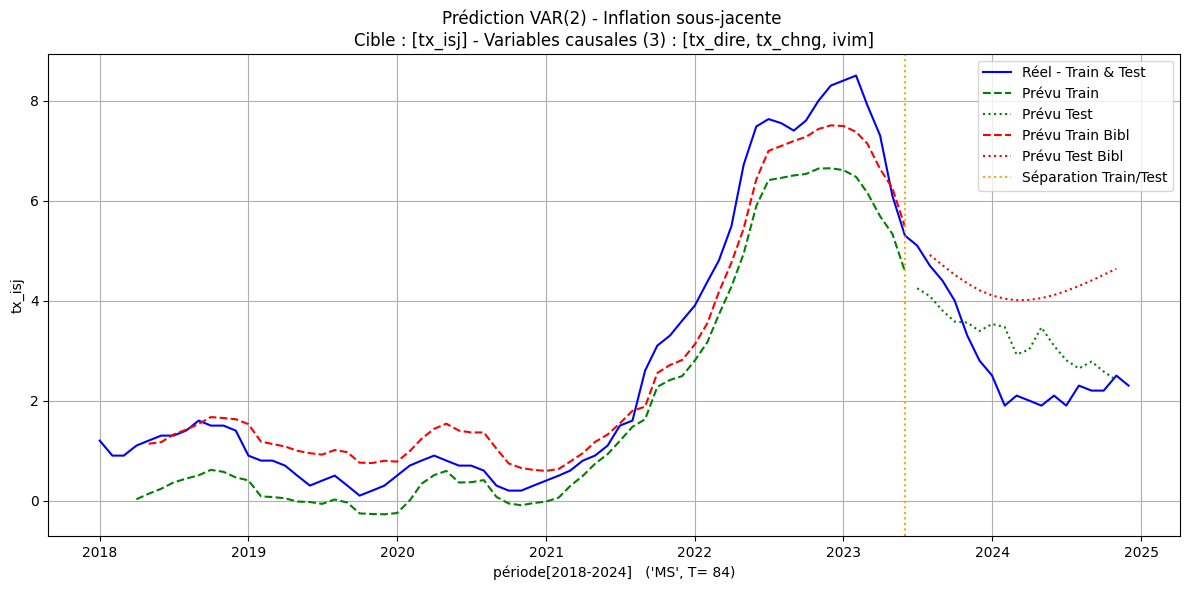


Test de causalit√© de Granger : les variables causales et les lags qui correpondent p = 1
  variable  lag  p_value
0  tx_dire    1    0.000
1  tx_chng    1    0.000
2     ivim    1    0.011
Cst :  (4, 1)
A1  :  (4, 4)
=> Performance de l'impl√®mentation manuelle de VAR(1) T = 84 :
   Train : MSE=0.8366 | MAE=0.7935 | R¬≤=0.8915
   Test  : MSE=0.2753 | MAE=0.4113 | R¬≤=0.7336
=> Performance de la Biblioth√®que VAR(1) T = 84 :
   Train : MSE=0.0575 | MAE=0.1706 | R¬≤=0.5608
   Test  : MSE=0.0709 | MAE=0.2136 | R¬≤=0.2362


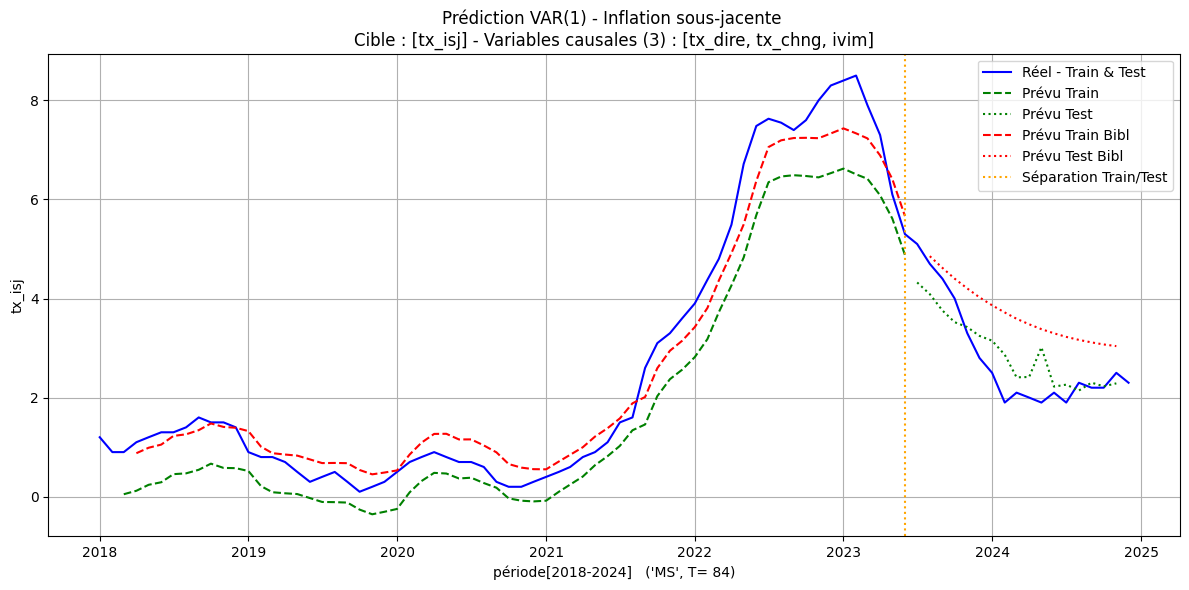

In [23]:
if len(train_var) == 0 or p_opt == 0 or p == 0:
  sys.exit("Vous devez recompiler le code d√©s le d√©but pour charger certains params !!")
if p_opt > 1 : p = p_opt - 1 
else : sys.exit("VAR(1) d√©ja effectu√© !!")
for p in range(p, 0, -1):
  test_causalite(train_var, p)
  df_stationnaire_reduit = df_stationnaire.drop(columns=non_causales)
  split_index, train_reduit, test_reduit = split_data(df_stationnaire_reduit)
  B_est, Y_est, residus, Sigma_u, T, k, _, _ = mco_multivariee(train_reduit, p)
  matrice_compagonon(B_est, p, k)
  df_reduit = df.drop(columns=non_causales)
  
  (train_real_man, train_pred_man, 
  test_real_man, test_pred_man) = pred_var(df_stationnaire_reduit, df_reduit, p)

  metriques(f"=> Performance de l'impl√®mentation manuelle de VAR({p}) T = {84 if freq=="MS" else 28} :", 
            train_real_man, train_pred_man, 
            test_real_man, test_pred_man)
  
  (train_real_bibl, train_pred_bibl, 
  test_real_bibl, test_pred_bibl, 
  train_pred_orig, forecast_df_orig) = bibl_var(p)

  metriques(f"=> Performance de la Biblioth√®que VAR({p}) T = {84 if freq=="MS" else 28} :", 
            train_real_bibl, train_pred_bibl, 
            test_real_bibl, test_pred_bibl)
  
  causal_vars = [col for col in df_reduit.columns if col != target]
  visualisation(f"Pr√©diction VAR({p}) - Inflation sous-jacente \nCible : [{target}] - "
              f"Variables causales ({len(causal_vars)}) : [{', '.join(causal_vars)}]", 
                train_var, test_var,
                train_pred_man[p+d:], test_pred_man[d:],
                train_pred_orig[target][d:], forecast_df_orig[target], 
                p, d, freq)
    

##### 2.3. Analyse :

<pre>
    <table>
        <tr><th>T</th><th>Impl√®mentation manuelle vs Usage du biblioth√®que</th></tr>
        <tr>
            <td>28</td>
            <td>
=> Performance de l'impl√®mentation manuelle de VAR(1) T = 28:
   Train : MSE=5.0867 | MAE=1.8160 | R¬≤=0.1347
   Test  : MSE=9.8068 | MAE=2.9815 | R¬≤=-1.0821
=> Performance de la Biblioth√®que VAR(1) T = 28:
   Train : MSE=0.1358 | MAE=0.2887 | R¬≤=0.8496
   Test  : MSE=1.1679 | MAE=0.8743 | R¬≤=-1.6054
            </td>
        </tr>
        <tr>
            <td>84</td>
            <td>
=> Performance de l'impl√®mentation manuelle de VAR(1) T = 84 :
   Train : MSE=0.8366 | MAE=0.7935 | R¬≤=0.8915
   Test  : MSE=0.2753 | MAE=0.4113 | R¬≤=0.7336
=> Performance de la Biblioth√®que VAR(1) T = 84 :
   Train : MSE=0.0575 | MAE=0.1706 | R¬≤=0.5608
   Test  : MSE=0.0709 | MAE=0.2136 | R¬≤=0.2362
            </td>
        </tr>
    </table>
</pre>
Le mod√©l VAR d'ordre 1 avec √©chantillon r√©duit (T=28) n'a pas donn√©e de resultat satisfaisant, une augmentation de nombre d'observation, le mod√©le a pu apprendre et g√©n√©raliser mais moins perforamant :<br/>
nous avons pass√© de VAR(3) qui n a pas pu expliquer la variabilit√© des donn√©es (moins performant qu'une moyenne), puis p=2, moins perforant puis p = 1, qui a donn√©e un r√©sultat moins perforamnt mais prometeuse.
</br>
Le mod√®le VAR a pu capturer la dynamique structurelle de l'inflation sous-jacente en d√©tectant le variables qui impacte directement l'inflation sous-jacente (d√©ctection d'interd√©pendances lin√©aires) √† savoir :<br/>
le taux directeur : instrument de la politique mon√©taire 
le tx de change : dans un r√©gime de change fixe, la variation du taux de change n‚Äôa pas un grand effet sur l‚Äôinflation. En revanche, dans un r√©gime de change flottant, ses fluctuations peuvent dynamiser ou accentuer l‚Äôinflation. 
l'indice des valeur √† l'importation : Suivre l‚Äôinflation import√©e.
Nous devons chercher √† pr√©sent d'autre relation existant entre les variables et leurs pass√©es.



#### üîπ R√©seau de Neurones (RNA)

##### 3.1 - Impl√®menation manuelle :

In [24]:
freq = "MS" # {"MS"|"QS"}  √©chantillon: {√©tendu|reduit} Freq: {Mensuelle|Trimestrielle}
df = reload_data(freq) 
target = 'tx_isj'

In [25]:
# S√©lection des variables
k = 4 # {1|4|7}  {univari√©|multivari√© simple|multivari√© complexe}

target = 'tx_isj'
if k == 1 : variables = ['tx_isj']
elif k == 4 : variables = ['tx_isj', 'tx_chng', 'tx_dire', 'ivim']
else: variables = ['tx_isj', 'mm', 'tx_dire', 'tx_chng', 'tx_chmg', 'tx_croi', 'ivim']

# 1 - pr√©paration des donn√©es : {(label, features)} selon les retards p
p = 1
for var in variables: 
    columns = [] 
    for lag in range(1, p + 1):  
        df[f"{var}_t-{lag}"] = df[var].shift(lag)

df_clean = df.dropna()# Nettoyage

# Pr√©paration X et y
X_columns = [f"{var}_t-{lag}" for var in variables for lag in range(1, p + 1)]
X = df_clean[X_columns].values # les features 
y = df_clean['tx_isj'].values.reshape(-1, 1) # le label

# 2 - Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"features (Entrainement) : {X_train.shape}, label (Entrainement) : {y_train.shape}")
print(f"features (Teste)        : {X_test.shape}, label (Teste)        : {y_test.shape}")

# Normalisation | Standarisation
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

features (Entrainement) : (66, 4), label (Entrainement) : (66, 1)
features (Teste)        : (17, 4), label (Teste)        : (17, 1)


In [26]:
# 2 - Initialisation du mod√®le
T, k = X_train_scaled.shape

h = 4  # Nombre de neurones cach√©s 

np.random.seed(0)
W1 = np.random.randn(k, h) * np.sqrt(2 / k)
b1 = np.zeros((1, h))
W2 = np.random.randn(h, 1) * np.sqrt(2 / h)
b2 = np.zeros((1, 1))

# Fonctions d'activation
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

# Entra√Ænement
epochs = 2500
lr = 0.075

patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # === la propagation ===
    Z1 = X_train_scaled @ W1 + b1
    
    A1 = relu(Z1)
    y_pred = A1 @ W2 + b2

    # L1 + L2 regularisation (on peut garder L1+L2 ensemble = r√©gularisation mixte)
    lambda_l2 = 0.01
    lambda_l1 = 0.01
    l2_reg = lambda_l2 * (np.sum(W1**2) + np.sum(W2**2)) # r√©g. ridge
    l1_reg = lambda_l1 * (np.sum(np.abs(W1)) + np.sum(np.abs(W2))) #r√©g. lasso
    loss = np.mean((y_train_scaled - y_pred)**2) + l2_reg + l1_reg # mse + r√©g.

    # === la r√©tro-propagation ===
    dL = 2 / T * (y_pred - y_train_scaled) # d/d{y_pred}(mse)
    dW2 = A1.T @ dL + 2*lambda_l2*W2 + lambda_l1*np.sign(W2)
    db2 = np.sum(dL, axis=0, keepdims=True)
    dA1 = dL @ W2.T
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = X_train_scaled.T @ dZ1 + 2*lambda_l2*W1 + lambda_l1*np.sign(W1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # Mise √† jour des poids
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # === Forward (validation) ===
    Z1_val = X_train_scaled @ W1 + b1
    A1_val = relu(Z1_val)
    y_val_pred = A1_val @ W2 + b2
    val_loss = np.mean((y_train_scaled - y_val_pred)**2) + \
               lambda_l2 * (np.sum(W1**2) + np.sum(W2**2)) + \
               lambda_l1 * (np.sum(np.abs(W1)) + np.sum(np.abs(W2)))

    # === Early stopping ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # sauvegarde des poids
        best_W1, best_b1 = W1.copy(), b1.copy()
        best_W2, best_b2 = W2.copy(), b2.copy()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping √† l'epoch {epoch+1}")
        break

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

# Restaure les meilleurs poids
W1, b1 = best_W1, best_b1
W2, b2 = best_W2, best_b2

Epoch   0 | Train Loss: 2.24360 | Val Loss: 1.20983
Epoch  50 | Train Loss: 0.20161 | Val Loss: 0.20091
Epoch 100 | Train Loss: 0.16553 | Val Loss: 0.16486
Epoch 150 | Train Loss: 0.13667 | Val Loss: 0.13616
Epoch 200 | Train Loss: 0.11575 | Val Loss: 0.11542
Epoch 250 | Train Loss: 0.10067 | Val Loss: 0.10041
Epoch 300 | Train Loss: 0.08832 | Val Loss: 0.08808
Epoch 350 | Train Loss: 0.07552 | Val Loss: 0.07528
Epoch 400 | Train Loss: 0.06581 | Val Loss: 0.06566
Epoch 450 | Train Loss: 0.05925 | Val Loss: 0.05915
Epoch 500 | Train Loss: 0.05507 | Val Loss: 0.05502
Epoch 550 | Train Loss: 0.05217 | Val Loss: 0.05212
Epoch 600 | Train Loss: 0.05011 | Val Loss: 0.05009
Epoch 650 | Train Loss: 0.04866 | Val Loss: 0.04864
Epoch 700 | Train Loss: 0.04768 | Val Loss: 0.04767
Epoch 750 | Train Loss: 0.04677 | Val Loss: 0.04678
Epoch 800 | Train Loss: 0.04595 | Val Loss: 0.04593
Epoch 850 | Train Loss: 0.04532 | Val Loss: 0.04530
Epoch 900 | Train Loss: 0.04478 | Val Loss: 0.04476
Epoch 950 | 

In [27]:
# 3 - Pr√©dictions :
# sur train
Z1_train = X_train_scaled @ W1 + b1
A1_train = relu(Z1_train)
y_train_pred_scaled = A1_train @ W2 + b2
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled).flatten()

# sur test
Z1_test = X_test_scaled @ W1 + b1
A1_test = relu(Z1_test)
y_test_pred_scaled = A1_test @ W2 + b2
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).flatten()

In [28]:
# 4 - Calcul des m√©triques
metriques(f"=> Performance de l'impl√®mentation manuelle de RNA(k = {k}, p = {p}, h = {h})"\
          f" T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

=> Performance de l'impl√®mentation manuelle de RNA(k = 4, p = 1, h = 4) T = 84:
   Train : MSE=0.0678 | MAE=0.1999 | R¬≤=0.9913
   Test  : MSE=0.5655 | MAE=0.6693 | R¬≤=0.2572


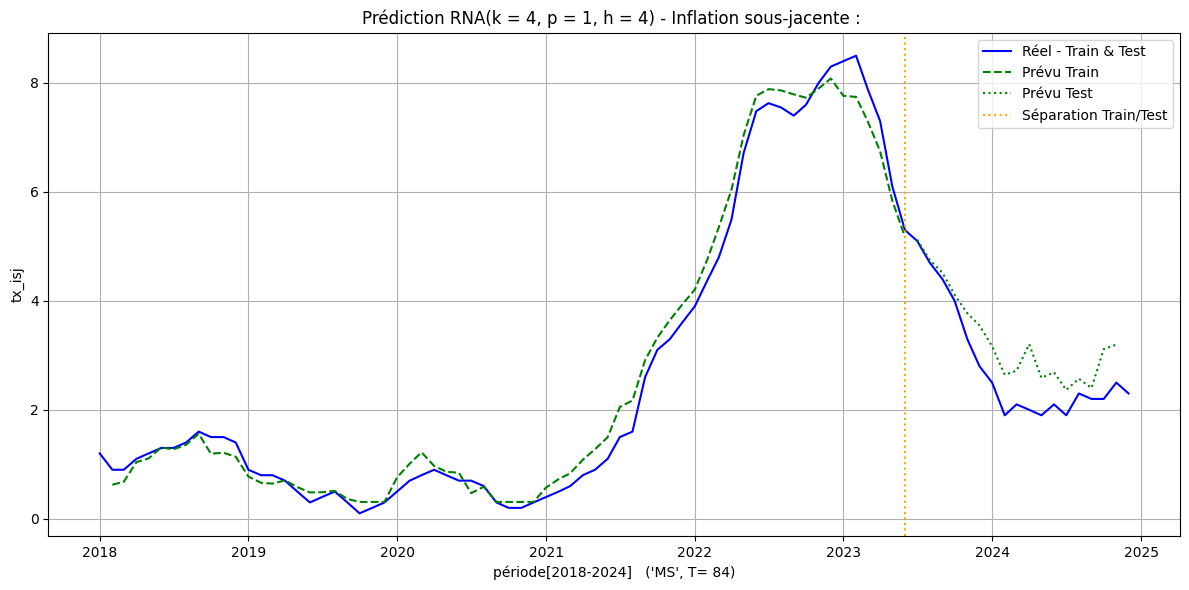

In [29]:
visualisation(f"Pr√©diction RNA(k = {k}, p = {p}, h = {h}) - Inflation sous-jacente : ", 
                y_train, y_test,
                y_train_pred[p:], y_test_pred,
                [], [], 
                p, 0, freq)

##### 3.2. Utilisation de la biblioth√©que : 

3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 24ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 44ms/step
=> Performance de la biblioth√®que de RNA(k = 4, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.0452 | MAE=0.1568 | R¬≤=0.9942
   Test  : MSE=0.2235 | MAE=0.3466 | R¬≤=0.7065


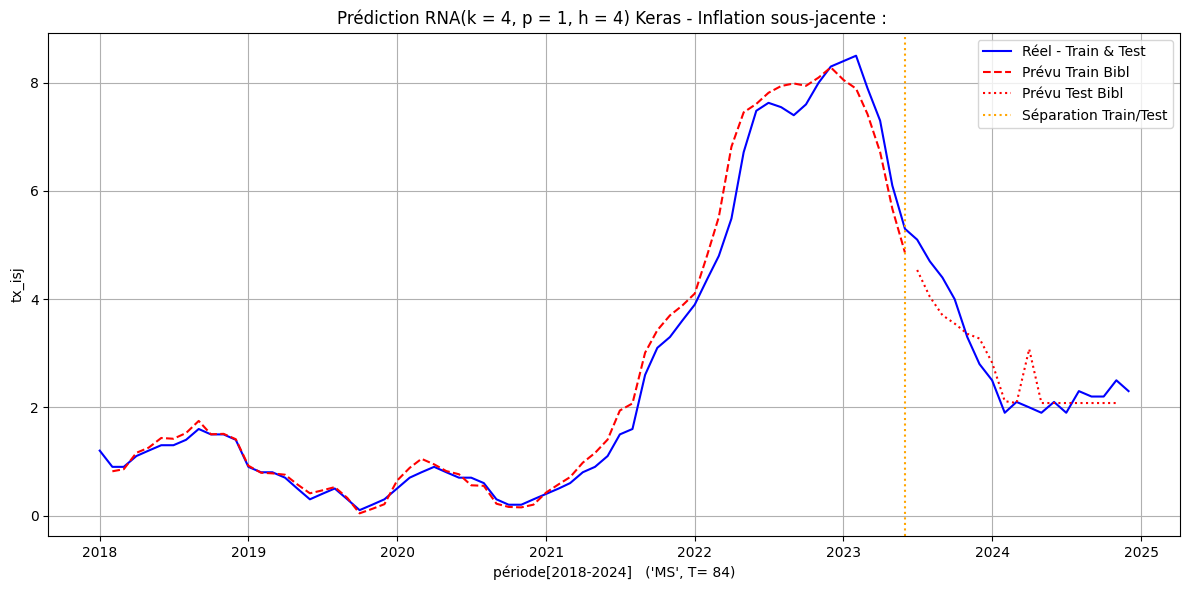

In [30]:
# L'utilisation du Biblioth√®que Kersa de tensorflow
# Conversion tensorflow/keras

# 1 - Fixer toutes les graines (pour poids, donn√©es, etc.){pour reproduire les m√™mes resultats}
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)# contr√¥le les poids initiaux et les op√©rations al√©atoires internes
random.seed(seed)

# 2 - D√©finir un initialiseur d√©terministe
initializer = keras.initializers.GlorotUniform(seed=seed)# fixe l‚Äôal√©a d‚Äôinitialisation des poids

model = keras.Sequential([
    keras.layers.Dense(
        h,
        activation='relu',
        input_shape=(X_train.shape[1],),
        kernel_initializer=initializer,  # pour 
        bias_initializer='zeros'         # optionnel (par d√©faut 0)
    ),
    keras.layers.Dense(
        1,
        kernel_initializer=initializer,  #
        bias_initializer='zeros'
    )
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
# Entra√Ænement
model.fit(X_train_scaled, y_train_scaled, epochs=epochs, verbose=0)

# Pr√©dictions
y_train_pred_keras = scaler_y.inverse_transform(model.predict(X_train_scaled)).ravel()
y_test_pred_keras  = scaler_y.inverse_transform(model.predict(X_test_scaled)).ravel()

metriques(f"=> Performance de la biblioth√®que de RNA(k = {k}, p = {p}, h = {h}) "\
          f"- Keras T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred_keras, 
          y_test, y_test_pred_keras)

visualisation(f"Pr√©diction RNA(k = {k}, p = {p}, h = {h}) Keras - Inflation sous-jacente : ", 
                y_train, y_test, 
                [], [],
                y_train_pred_keras[p:], y_test_pred_keras, 
                p, 0, freq)



=> Performance de l'impl√®mentation manuelle de RNA(k = 4, p = 1, h = 4) T = 84:
   Train : MSE=0.0678 | MAE=0.1999 | R¬≤=0.9913
   Test  : MSE=0.5655 | MAE=0.6693 | R¬≤=0.2572
=> Performance de la biblioth√®que de RNA(k = 4, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.0452 | MAE=0.1568 | R¬≤=0.9942
   Test  : MSE=0.2235 | MAE=0.3466 | R¬≤=0.7065


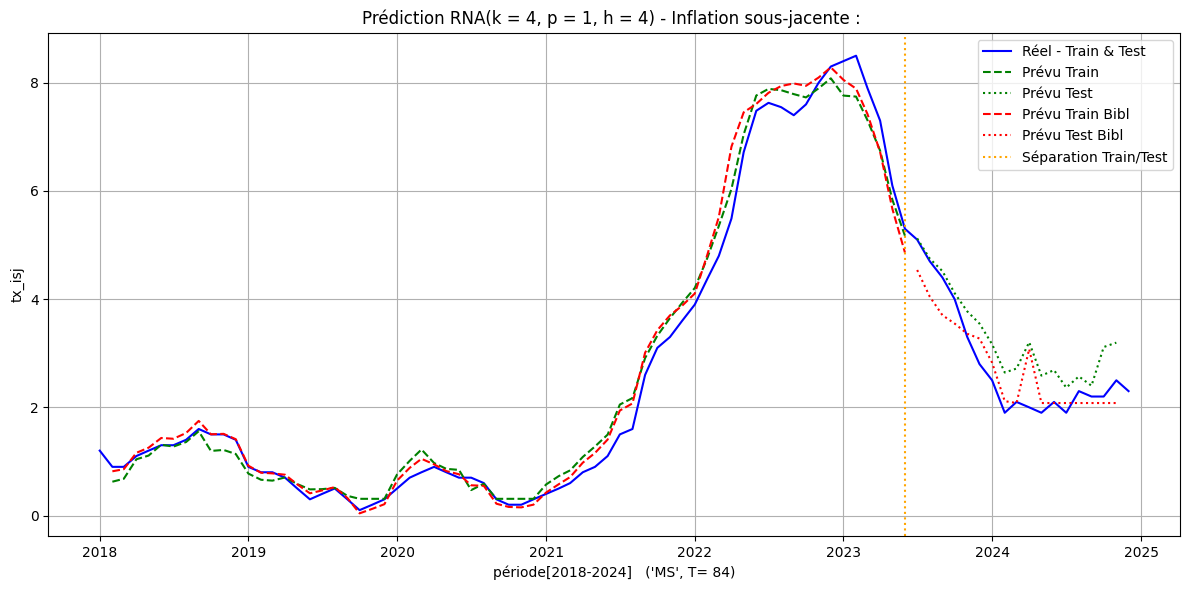

In [31]:
# 4 - Calcul des m√©triques
metriques(f"=> Performance de l'impl√®mentation manuelle de RNA(k = {k}, p = {p}, h = {h}) "\
          f"T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

metriques(f"=> Performance de la biblioth√®que de RNA(k = {k}, p = {p}, h = {h}) - Keras "\
          f"T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred_keras, 
          y_test, y_test_pred_keras)

visualisation(f"Pr√©diction RNA(k = {k}, p = {p}, h = {h}) - Inflation sous-jacente : ",
                y_train, y_test, 
                y_train_pred[p:], y_test_pred,
                y_train_pred_keras[p:], y_test_pred_keras, 
                p, 0, freq)


##### 3.3. Analyse :

<pre>
    <table>
        <tr><th>T</th><th>Impl√®mentation manuelle vs Usage du biblioth√®que</th></tr>
        <tr>
            <td>28</td>
            <td>
=> Performance de l'impl√®mentation manuelle de RNA(k = 1, p = 1, h = 4) T = 28:
   Train : MSE=0.4179 | MAE=0.4920 | R¬≤=0.9468
   Test  : MSE=2.4221 | MAE=1.2937 | R¬≤=-1.5223
=> Performance de la biblioth√®que de RNA(k = 1, p = 1, h = 4) - Keras T = 28:
   Train : MSE=0.2956 | MAE=0.4173 | R¬≤=0.9624
   Test  : MSE=4.6155 | MAE=1.7051 | R¬≤=-3.8066

=> Performance de l'impl√®mentation manuelle de RNA(k = 4, p = 1, h = 4) T = 28:
   Train : MSE=0.1169 | MAE=0.2838 | R¬≤=0.9851
   Test  : MSE=1.0545 | MAE=0.8210 | R¬≤=-0.0981
=> Performance de la biblioth√®que de RNA(k = 4, p = 1, h = 4) - Keras T = 28:
   Train : MSE=0.0728 | MAE=0.2044 | R¬≤=0.9907
   Test  : MSE=2.3715 | MAE=1.1869 | R¬≤=-1.4697

=> Performance de l'impl√®mentation manuelle de RNA(k = 7, p = 1, h = 4) T = 28:
   Train : MSE=0.1415 | MAE=0.3196 | R¬≤=0.9820
   Test  : MSE=7.2124 | MAE=2.5251 | R¬≤=-6.5110
=> Performance de la biblioth√®que de RNA(k = 7, p = 1, h = 4) - Keras T = 28:
   Train : MSE=0.0128 | MAE=0.0948 | R¬≤=0.9984
   Test  : MSE=9.2059 | MAE=2.8767 | R¬≤=-8.5870
            </td>
        </tr>
        <tr>
            <td>84</td>
            <td>
=> Performance de l'impl√®mentation manuelle de RNA(k = 1, p = 1, h = 4) T = 84:
   Train : MSE=0.1324 | MAE=0.2454 | R¬≤=0.9830
   Test  : MSE=0.1332 | MAE=0.3150 | R¬≤=0.8251
=> Performance de la biblioth√®que de RNA(k = 1, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.1300 | MAE=0.2361 | R¬≤=0.9833
   Test  : MSE=0.3612 | MAE=0.5019 | R¬≤=0.5256
   
=> Performance de l'impl√®mentation manuelle de RNA(k = 4, p = 1, h = 4) T = 84:
   Train : MSE=0.0678 | MAE=0.1999 | R¬≤=0.9913
   Test  : MSE=0.5655 | MAE=0.6693 | R¬≤=0.2572
=> Performance de la biblioth√®que de RNA(k = 4, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.0452 | MAE=0.1571 | R¬≤=0.9942
   Test  : MSE=0.2219 | MAE=0.3447 | R¬≤=0.7086
   
=> Performance de l'impl√®mentation manuelle de RNA(k = 7, p = 1, h = 4) T = 84:
   Train : MSE=0.0635 | MAE=0.1917 | R¬≤=0.9918
   Test  : MSE=0.5109 | MAE=0.6224 | R¬≤=0.3289
=> Performance de la biblioth√®que de RNA(k = 7, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.0323 | MAE=0.1403 | R¬≤=0.9958
   Test  : MSE=0.3418 | MAE=0.5248 | R¬≤=0.5510
            </td>
        </tr>
    </table>
</pre>

Sur un √©chantillon r√©duit, le mod√©le RNA n'a pas pu g√©n√©ralis√©e, le mod√®le m√©morise les donn√©es d‚Äôentra√Ænement, ce qui se traduit par un R¬≤ tr√®s √©lev√© sur l‚Äô√©chantillon d‚Äôapprentissage mais n√©gatif sur l‚Äô√©chantillon de test. 

Sur un √©chantillon √©tendu, et en s‚Äôappuyant uniquement sur les donn√©es pass√©es de l‚ÄôISJ, l‚Äôimpl√©mentation manuelle du RNA a donn√© de bons r√©sultats, avec un MSE quasi constant entre l‚Äôentra√Ænement et le test et seulement une l√©g√®re baisse du R¬≤. En revanche, la biblioth√®que Keras s‚Äôest r√©v√©l√©e moins performante. Lorsqu‚Äôon utilise des donn√©es multivari√©es, qu‚Äôelles soient simples ou complexes, bien que les R¬≤ demeurent positifs, on observe une forte augmentation du MSE entre l‚Äôentra√Ænement et le test, ce qui constitue un signe de sur-apprentissage.


#### üîπ XGBoost

In [32]:
# Initialisation
freq = "MS" # {"MS"|"QS"}  √©chantillon: {√©tendu|reduit} Freq: {Mensuelle|Trimestrielle}
df = reload_data(freq) 
target = 'tx_isj'

p = 1
k = 4 # {1|4|7}  {univari√©|multivari√© simple|multivari√© complexe}

if k == 1 : variables = ['tx_isj']
elif k == 4 : variables = ['tx_isj', 'tx_chng', 'tx_dire', 'ivim']
else: variables = ['tx_isj', 'mm', 'tx_dire', 'tx_chng', 'tx_chmg', 'tx_croi', 'ivim']

##### 4.1 - Impl√®menation manuelle :

In [33]:
# 1 - pr√©paration des donn√©es : {(label, features)} selon les retards p
for var in variables: 
    columns = [] 
    for lag in range(1, p + 1):  
        df[f"{var}_t-{lag}"] = df[var].shift(lag)

df_clean = df.dropna()# Nettoyage

# Pr√©paration X et y
X_columns = [f"{var}_t-{lag}" for var in variables for lag in range(1, p + 1)]
X = df_clean[X_columns].values # les features 
y = df_clean['tx_isj'].values.reshape(-1, 1) # le label

# 2 - Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"features (Entrainement) : {X_train.shape}, label (Entrainement) : {y_train.shape}")
print(f"features (Teste)        : {X_test.shape}, label (Teste)        : {y_test.shape}")

features (Entrainement) : (66, 4), label (Entrainement) : (66, 1)
features (Teste)        : (17, 4), label (Teste)        : (17, 1)


In [34]:
# 1. Initialisation
F_0 = np.mean(y_train)  # moyenne des donn√©es d'entra√Ænement
F_t_train = np.full_like(y_train, F_0)
trees = []
learning_rate = 0.01
n_estimators = 1000

patience = 5  # Nombre d'it√©rations sans am√©lioration tol√©r√©es
min_delta = 1e-5  # Am√©lioration minimale du MSE
best_val_mse = float('inf')
patience_counter = 0

lambda_reg = 0.01

# 2. Boosting : entra√Ænement sur le train
for t in range(n_estimators):
    # Gradient et Hessien
    g = F_t_train - y_train  # Gradient
    h = np.ones_like(g)      # Hessien constant (MSE)

    # Pseudo-r√©sidus
    pseudo_residual = -g / h

    # Arbre sur les r√©sidus
    tree = DecisionTreeRegressor(max_depth=3, random_state=42)
    tree.fit(X_train, pseudo_residual)
    update = tree.predict(X_train)
    
    # Mise √† jour
    update = update.reshape(-1,1)
    F_t_train += learning_rate * update
    trees.append(tree)

    # MSE d'entra√Ænement
    mse = mean_squared_error(y_train, F_t_train) # sans r√©gularisation
    mse = mean_squared_error(y_train, F_t_train) + lambda_reg * np.sum(update**2)
    print(f"Iteration {t+1} - Train MSE: {mse:.4f}")

    # Early stopping
    if mse + min_delta < best_val_mse:
        best_val_mse = mse
        best_iteration = t
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping √† l'it√©ration {t+1} (meilleur Val MSE = {best_val_mse:.4f} √† l‚Äôit√©ration {best_iteration+1})")
            break

# 3. Fonction de pr√©diction finale
def predict_boosted(X_input, trees, F_0, lr):
    y_hat = np.full(X_input.shape[0], F_0)
    for tree in trees:
        y_hat += lr * tree.predict(X_input)
    return y_hat


Iteration 1 - Train MSE: 12.7037
Iteration 2 - Train MSE: 12.4523
Iteration 3 - Train MSE: 12.2060
Iteration 4 - Train MSE: 11.9645
Iteration 5 - Train MSE: 11.7279
Iteration 6 - Train MSE: 11.4960
Iteration 7 - Train MSE: 11.2687
Iteration 8 - Train MSE: 11.0452
Iteration 9 - Train MSE: 10.8278
Iteration 10 - Train MSE: 10.6139
Iteration 11 - Train MSE: 10.4036
Iteration 12 - Train MSE: 10.1991
Iteration 13 - Train MSE: 9.9970
Iteration 14 - Train MSE: 9.8005
Iteration 15 - Train MSE: 9.6069
Iteration 16 - Train MSE: 9.4170
Iteration 17 - Train MSE: 9.2317
Iteration 18 - Train MSE: 9.0495
Iteration 19 - Train MSE: 8.8707
Iteration 20 - Train MSE: 8.6961
Iteration 21 - Train MSE: 8.5247
Iteration 22 - Train MSE: 8.3562
Iteration 23 - Train MSE: 8.1920
Iteration 24 - Train MSE: 8.0303
Iteration 25 - Train MSE: 7.8719
Iteration 26 - Train MSE: 7.7170
Iteration 27 - Train MSE: 7.5650
Iteration 28 - Train MSE: 7.4158
Iteration 29 - Train MSE: 7.2698
Iteration 30 - Train MSE: 7.1267
Iterati

In [35]:
# 4. Pr√©dictions finales
y_train_pred = predict_boosted(X_train, trees, F_0, learning_rate)
y_test_pred = predict_boosted(X_test, trees, F_0, learning_rate)

# 5. Dates pour les trac√©s
dates_train = df_clean.index[:len(y_train)]
dates_test = df_clean.index[-len(y_test):]

In [36]:
# 4 - Calcul des m√©triques
metriques(f"=> Performance de l'impl√®mentation manuelle de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

=> Performance de l'impl√®mentation manuelle de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0061 | MAE=0.0594 | R¬≤=0.9992
   Test  : MSE=0.9197 | MAE=0.9055 | R¬≤=-0.2081


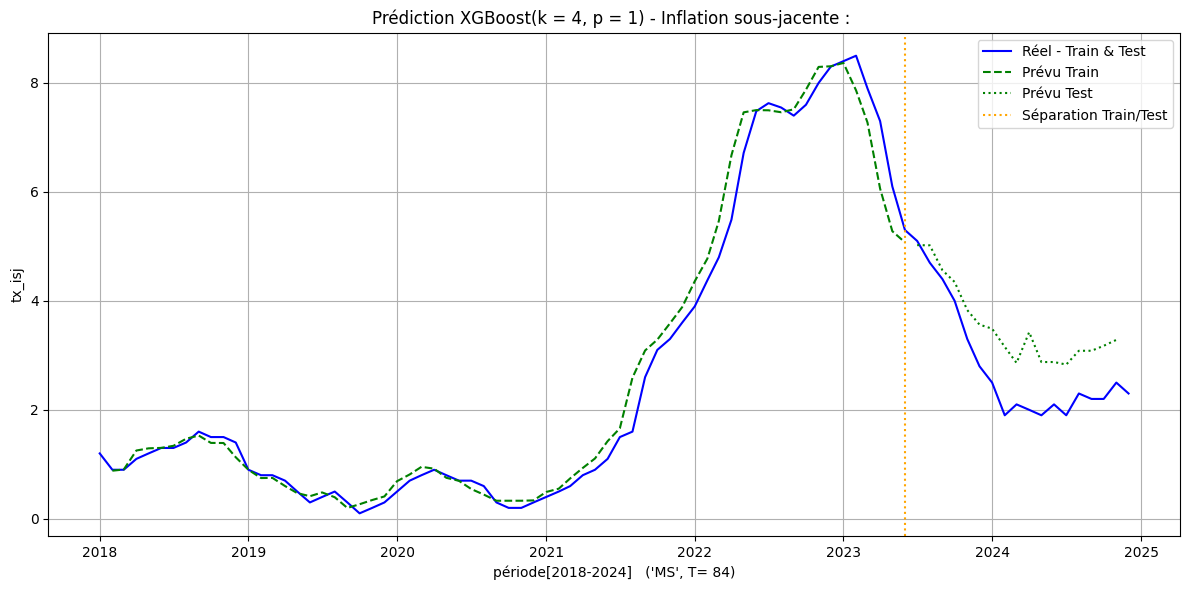

In [37]:
visualisation(f"Pr√©diction XGBoost(k = {k}, p = {p}) - Inflation sous-jacente : ", 
                y_train, y_test,
                y_train_pred[p:], y_test_pred,
                [], [], 
                p, 0, freq)

##### 3.2. Utilisation de la biblioth√©que : XGBRegressor

=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0017 | MAE=0.0319 | R¬≤=0.9998
   Test  : MSE=0.3213 | MAE=0.5128 | R¬≤=0.5780


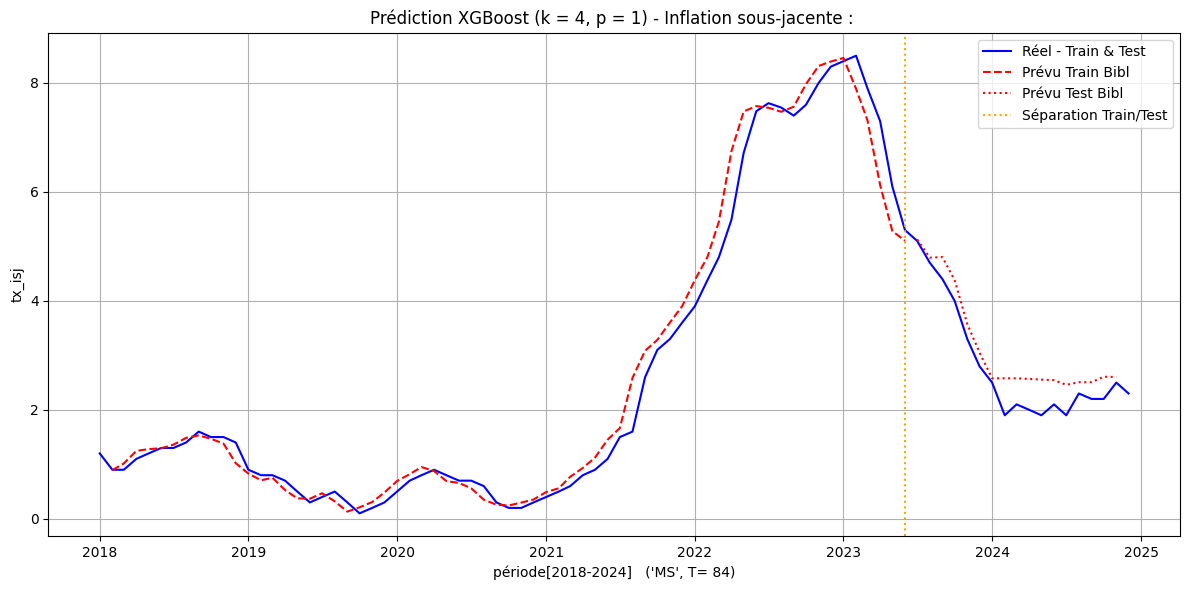

In [38]:
# l'utilisation de biblioth√®que : XGBRegressor
model = XGBRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)
# Pr√©dictions
y_train_pred_bibl = model.predict(X_train)
y_test_pred_bibl = model.predict(X_test)

metriques(f"=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred_bibl,
          y_test, y_test_pred_bibl)

visualisation(f"Pr√©diction XGBoost (k = {k}, p = {p}) - Inflation sous-jacente : ", 
                y_train, y_test,
                [], [],
                y_train_pred_bibl[p:], y_test_pred_bibl, 
                p, 0, freq)

=> Performance de l'impl√®mentation manuelle de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0061 | MAE=0.0594 | R¬≤=0.9992
   Test  : MSE=0.9197 | MAE=0.9055 | R¬≤=-0.2081
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0017 | MAE=0.0319 | R¬≤=0.9998
   Test  : MSE=0.3213 | MAE=0.5128 | R¬≤=0.5780


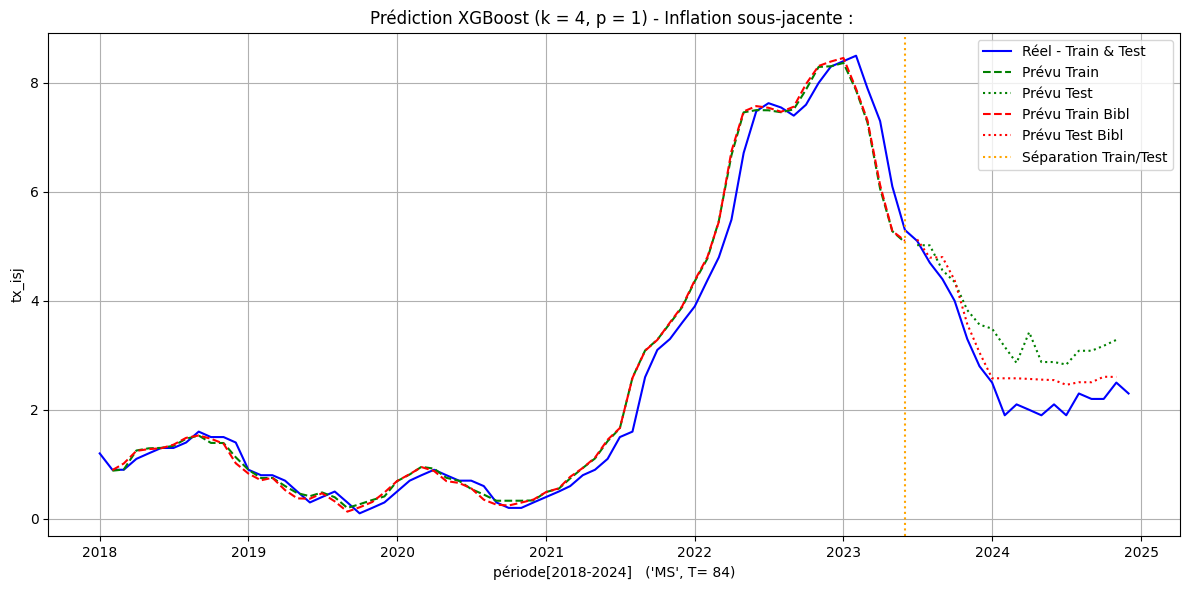

In [39]:
metriques(f"=> Performance de l'impl√®mentation manuelle de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

metriques(f"=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred_bibl,
          y_test, y_test_pred_bibl)

visualisation(f"Pr√©diction XGBoost (k = {k}, p = {p}) - Inflation sous-jacente : ", 
                y_train, y_test,
                y_train_pred[p:], y_test_pred,
                y_train_pred_bibl[p:], y_test_pred_bibl, 
                p, 0, freq)

##### 4.1 - Analyse :

<pre>
    <table>
        <tr><th>T</th><th>Impl√®mentation manuelle vs Usage du biblioth√®que</th></tr>
        <tr>
            <td>28</td>
            <td>
=> Performance de l'impl√®mentation manuelle de XGBoost(k = 1, p = 1, T = 28) :
   Train : MSE=0.0472 | MAE=0.1854 | R¬≤=0.9940
   Test  : MSE=4.0554 | MAE=1.8541 | R¬≤=-3.2233
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 1, p = 1, T = 28) :
   Train : MSE=0.1299 | MAE=0.2891 | R¬≤=0.9835
   Test  : MSE=3.0544 | MAE=1.6065 | R¬≤=-2.1809

=> Performance de l'impl√®mentation manuelle de XGBoost(k = 4, p = 1, T = 28) :
   Train : MSE=0.0249 | MAE=0.1226 | R¬≤=0.9968
   Test  : MSE=2.4273 | MAE=1.4517 | R¬≤=-1.5277
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 4, p = 1, T = 28) :
   Train : MSE=0.0966 | MAE=0.2258 | R¬≤=0.9877
   Test  : MSE=2.3902 | MAE=1.4399 | R¬≤=-1.4892

=> Performance de l'impl√®mentation manuelle de XGBoost(k = 7, p = 1, T = 28) :
   Train : MSE=0.0245 | MAE=0.1225 | R¬≤=0.9969
   Test  : MSE=1.1868 | MAE=0.7516 | R¬≤=-0.2360
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 7, p = 1, T = 28) :
   Train : MSE=0.0946 | MAE=0.2186 | R¬≤=0.9879
   Test  : MSE=2.5561 | MAE=1.4989 | R¬≤=-1.6619
            </td>
        </tr>
        <tr>
            <td>84</td>
            <td>
=> Performance de l'impl√®mentation manuelle de XGBoost(k = 1, p = 1, T = 84) :
   Train : MSE=0.4516 | MAE=0.5511 | R¬≤=0.9419
   Test  : MSE=0.3089 | MAE=0.4487 | R¬≤=0.5942
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 1, p = 1, T = 84) :
   Train : MSE=0.5801 | MAE=0.6142 | R¬≤=0.9254
   Test  : MSE=0.0932 | MAE=0.2410 | R¬≤=0.8776

=> Performance de l'impl√®mentation manuelle de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0061 | MAE=0.0594 | R¬≤=0.9992
   Test  : MSE=0.9197 | MAE=0.9055 | R¬≤=-0.2081
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0078 | MAE=0.0684 | R¬≤=0.9990
   Test  : MSE=0.2892 | MAE=0.4819 | R¬≤=0.6201

=> Performance de l'impl√®mentation manuelle de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0029 | MAE=0.0426 | R¬≤=0.9996
   Test  : MSE=2.4861 | MAE=1.4726 | R¬≤=-2.2656
=> Performance de la biblioth√®que XGBRegressor de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0061 | MAE=0.0600 | R¬≤=0.9992
   Test  : MSE=0.2999 | MAE=0.4919 | R¬≤=0.6060
            </td>
        </tr>
    </table>
</pre>

Sur un √©chantillon r√©duit (T = 28, Freq = QS) le mod√©le XGBoost n'a pas pu g√©n√©ralis√©, il a captur√© les d√©tailles en entrainement, mais les MSE augmentent et les R¬≤ sont n√©gatives en toutes les situation (univari√©e k=1, multivari√©e simple k=4, et multivaari√©e complexe k = 7), montrant sa faiblesse de mod√®liser les √©chantillons de petites tailles.<br/>

Sur √©chantillon √©tendu (T 84 Freq = MS):<br/>
   - Sur des donn√©es univari√©es (en se basant uniquement sur l‚Äôhistorique de la variable cible avec un ordre p=1), XGBoost a donn√© des r√©sultats satisfaisants : le MSE diminue et le R¬≤ ne baisse que tr√®s l√©g√®rement sur les donn√©es non vues lors de l‚Äôutilisation de la biblioth√®que, tandis que l‚Äôimpl√©mentation manuelle pr√©sente une baisse un peu plus marqu√©e. Ces r√©sultats confirment la capacit√© de g√©n√©ralisation du mod√®le.
   - Sur les donn√©es mulivari√©es simple et complexe, le mod√©l XGBoost a pu g√©n√©raliser en utilsant la biblioth√©que XGBRegressor qui est plus robuste que l'impl√®mentation manuelle, malgr√© l'augmenation de MSe, la variance expliqu√©e par le mod√®le (R¬≤) est diminuer une peu; l'impl√®menation manuelle le chute de R¬≤ (n√©gative) montre que le mod√©le est sur-apprenti...

   - Explication : la biblioth√®que XGBRegressor, le MSE passe de 0,04 sur le jeu d‚Äôentra√Ænement √† 0,2 sur le jeu de test, tandis que le R¬≤ diminue de 0,99 √† 0,72. Cela montre que, malgr√© une l√©g√®re perte de performance sur les donn√©es non vues, le mod√®le conserve une bonne capacit√© de g√©n√©ralisation.

## 6. Comparaison des performances

In [40]:
import pandas as pd

# Donn√©es simplifi√©es pour d√©monstration
data = {
    "Mod√®le": [
        "ARIMA(4,1,2) T28","ARIMA(4,1,2) T28","ARIMA(10,1,8) T84","ARIMA(10,1,8) T84",
        "VAR(1) T28","VAR(1) T28","VAR(1) T84","VAR(1) T84",
        "RNA(k=1,p=1,h=4) T28","RNA(k=1,p=1,h=4) T28",
        "RNA(k=4,p=1,h=4) T28","RNA(k=4,p=1,h=4) T28",
        "RNA(k=7,p=1,h=4) T28","RNA(k=7,p=1,h=4) T28",
        "RNA(k=1,p=1,h=4) T84","RNA(k=1,p=1,h=4) T84",
        "RNA(k=4,p=1,h=4) T84","RNA(k=4,p=1,h=4) T84",
        "RNA(k=7,p=1,h=4) T84","RNA(k=7,p=1,h=4) T84",
        "XGBoost(k=1,p=1) T28","XGBoost(k=1,p=1) T28",
        "XGBoost(k=4,p=1) T28","XGBoost(k=4,p=1) T28",
        "XGBoost(k=7,p=1) T28","XGBoost(k=7,p=1) T28",
        "XGBoost(k=1,p=1) T84","XGBoost(k=1,p=1) T84",
        "XGBoost(k=4,p=1) T84","XGBoost(k=4,p=1) T84",
        "XGBoost(k=7,p=1) T84","XGBoost(k=7,p=1) T84"
    ],
    "Impl√©mentation": [
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que",
        "Manuelle","Biblioth√®que","Manuelle","Biblioth√®que"
    ],
    "Train": [
        "MSE=3.5926 | R¬≤=0.6050","MSE=0.2520 | R¬≤=0.9669",
        "MSE=1.0036 | R¬≤=0.8854","MSE=0.0554 | R¬≤=0.9928",
        "MSE=5.0867 | R¬≤=0.1347","MSE=0.1358 | R¬≤=0.8496",
        "MSE=0.8366 | R¬≤=0.8915","MSE=0.0575 | R¬≤=0.5608",
        "MSE=0.4179 | R¬≤=0.9468","MSE=0.2956 | R¬≤=0.9624",
        "MSE=0.1169 | R¬≤=0.9851","MSE=0.0728 | R¬≤=0.9907",
        "MSE=0.1415 | R¬≤=0.9820","MSE=0.0128 | R¬≤=0.9984",
        "MSE=0.1324 | R¬≤=0.9830","MSE=0.1300 | R¬≤=0.9833",
        "MSE=0.0678 | R¬≤=0.9913","MSE=0.0452 | R¬≤=0.9942",
        "MSE=0.0635 | R¬≤=0.9918","MSE=0.0323 | R¬≤=0.9958",
        "MSE=0.0472 | R¬≤=0.9940","MSE=0.1299 | R¬≤=0.9835",
        "MSE=0.0249 | R¬≤=0.9968","MSE=0.0966 | R¬≤=0.9877",
        "MSE=0.0245 | R¬≤=0.9969","MSE=0.0946 | R¬≤=0.9879",
        "MSE=0.4516 | R¬≤=0.9419","MSE=0.5801 | R¬≤=0.9254",
        "MSE=0.0061 | R¬≤=0.9992","MSE=0.0078 | R¬≤=0.9990",
        "MSE=0.0029 | R¬≤=0.9996","MSE=0.0061 | R¬≤=0.9992"
    ],
    "Test": [
        "MSE=16.9274 | R¬≤=-16.6282","MSE=1.5659 | R¬≤=-0.6308",
        "MSE=1.1968 | R¬≤=-0.5720","MSE=2.0529 | R¬≤=-1.6966",
        "MSE=9.8068 | R¬≤=-1.0821","MSE=1.1679 | R¬≤=-1.6054",
        "MSE=0.2753 | R¬≤=0.7336","MSE=0.0709 | R¬≤=0.2362",
        "MSE=2.4221 | R¬≤=-1.5223","MSE=4.6155 | R¬≤=-3.8066",
        "MSE=1.0545 | R¬≤=-0.0981","MSE=2.3715 | R¬≤=-1.4697",
        "MSE=7.2124 | R¬≤=-6.5110","MSE=9.2059 | R¬≤=-8.5870",
        "MSE=0.1332 | R¬≤=0.8251","MSE=0.3612 | R¬≤=0.5256",
        "MSE=0.5655 | R¬≤=0.2572","MSE=0.2219 | R¬≤=0.7086",
        "MSE=0.5109 | R¬≤=0.3289","MSE=0.3418 | R¬≤=0.5510",
        "MSE=4.0554 | R¬≤=-3.2233","MSE=3.0544 | R¬≤=-2.1809",
        "MSE=2.4273 | R¬≤=-1.5277","MSE=2.3902 | R¬≤=-1.4892",
        "MSE=1.1868 | R¬≤=-0.2360","MSE=2.5561 | R¬≤=-1.6619",
        "MSE=0.3089 | R¬≤=0.5942","MSE=0.0932 | R¬≤=0.8776",
        "MSE=0.9197 | R¬≤=-0.2081","MSE=0.2892 | R¬≤=0.6201",
        "MSE=2.4861 | R¬≤=-2.2656","MSE=0.2999 | R¬≤=0.6060"
    ]
}

df = pd.DataFrame(data, index=range(1, len(data["Mod√®le"])+1))

# Ajouter colonne validit√© selon R¬≤ test
def get_validity(r2_str):
    r2 = float(r2_str.split("| R¬≤=")[-1])
    return "‚úÖ" if r2 > 0 else "‚ùå"

df["Validit√©"] = df["Test"].apply(get_validity)

def highlight_icons(val):
    return 'color: green;' if val == "‚úÖ" else 'color: red;'

df.style.applymap(highlight_icons, subset=["Validit√©"]).set_properties(**{'text-align':'left'})

## 7. Conclusion

En s'apuyant uniquement sur les donn√©es pass√©es :
* ARIMA : n 'a pas pu g√©n√©raliser, mais il a donn√© des signes prometeuse en augmentant la tailles de l'√©chantillon.
* Les mod√®les de ML, RNA (15) et (16) et XCGoost (27) et (28) ont donn√© des r√©sultat satififaisant indiquant leurs capacit√©s de pr√©voir sur des donn√©es univari√©es√®(T=84), mais ont montr√© aussi leur faiblesse sur des petits √©chantillons(T=28).<br/>

Sur des √©chantillons simple (conteant que les variables causales) r√©duit et √©tendu :
* Les mod√®les VAR (5) et (6), RNA (11) et (12), XGBoost (23) et (25) n'ont pas pu g√©n√©raliser en sur-apprenant, ou parfois sous-apprenant sur un √©chnatillon r√©duit(T=28).
* Le mod√©le VAR sur un √©chatillon √©tendu (T=84) a pu g√©n√©raliser en impl√®mentation manuelle (7) et moins performant en utilisant la biblioth√®que VAR(8), il nous a permet de d√©terminer les variables qui ont des relations liniarire directe avec la variable cible.
* Les mod√®les ML sur un √©chantillon √©tendu (T=84), le RNA (17) et (18) ont pu g√©n√©raliser malgr√© que le MSE ont augment√©s, l'usage de biblioth√®que Keras est plus performant, presque m√™me r√©sultat avec le mod√®le XGBoost (30), l'implentation manuelle a sur-apprenti.

Sur des donn√©es multivari√©es complexes :
* Le mod√®le VAR n'est valid√© qu'apr√©s exclure les variables qui n'ont pas de relations lin√©aire avec la variables cibles, donc les mod√®les de machines ML qui prenent en charger les relations lin√©aires et non-lin√©aires, Les RNA (19) et (20) ont pu g√©n√©raliser avec une performance mod√©r√©e, la biblioth√®que XGBRogresser (32) a donn√© un r√©sultat meilleur, mais l'impl√®mentation manuelle a sur-apprenti.